In [1]:
import nest
import network
import addons
import numpy as np
from network_params import net_dict
import network_params
from sim_params import sim_dict
from stimulus_params import stim_dict
from scipy.signal import argrelextrema
import nest
import pickle
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



/home/hyc_1/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning:Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.


In [2]:
def filter_signal(data,fs,lowcut,highcut,order=3):

    return addons.butter_bandpass_filter(data,lowcut,highcut,fs,order)

In [3]:
def filter_signal(data,fs,lowcut,highcut,order=3):

    return addons.butter_bandpass_filter(data,lowcut,highcut,fs,order)

In [4]:
from scipy import signal
from scipy.signal import butter, lfilter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def compute_FFT(signal_data,freq_sample= 0.001,freq_sample_welsh = 1000,lim_y = 7000, lim_x = 200, low_log = 10, high_log =90,fit=False,fit_freq_start = 5, fit_freq_end = 25,test_p0 = [1,10,2],welsh_fit = 'alpha',signal_xmin=950,signal_xmax=1050,save=True,name_='freq.dat',plot=True,p0 =[1000,80,5]):


    bg_rates = [6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0]
    bg_rates = [6.0,8.0]
    #analysis_interval_start = 0
    #analysis_interval_end = 999
    FFT_Results = {}
    Welsh_Freqs = {}
    time_pop = np.linspace(950,1450,num=int((1450-950)/0.2))
    Welsh_Powers = {}
    if fit:
        Fit_FFT = {}
        Fit_Welsh = {}
        mean_freq = []
        mean_welsh = []
        amplitude_freq = []
        amplitude_welsh = []
        sigma_freq = []
        sigma_welsh = []
        def gaus(x, a, x0, sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))


    for i in range(len(signal_data)):
        FFT_Results[i] = fft(signal_data[i]-np.mean(signal_data[i]))
        Welsh_Freqs[i], Welsh_Powers[i]  = signal.welch(signal_data[i]-np.mean(signal_data[i]),fs=freq_sample_welsh)
        #FFT_Results[i] = fft(signal_data[i][analysis_interval_start:analysis_interval_end])
        #Welsh_Freqs[i], Welsh_Powers[i]  = signal.welch(signal_data[i][analysis_interval_start:analysis_interval_end],fs=freq_sample_welsh)

    #Calcular los valores de frequencia correspondientes
    #freq = fftfreq(len(signal_data[i][analysis_interval_start:analysis_interval_end]),d=freq_sample) * 1000
    freq = fftfreq(len(signal_data[i]),d=freq_sample)
    if fit:
        index_start = int(np.argwhere(np.abs(freq-fit_freq_start)<2)[0][0])
        index_end = int(np.argwhere(np.abs(freq-fit_freq_end)<2)[0][0])

    if plot:
        plt.figure(figsize=(25, 7))
        colors = ['#e3342f', '#f6993f', '#ffed4a', '#38c172', '#4dc0b5', '#3490dc', '#6574cd', '#9561e2', '#f66d9b','pink', 'black', 'gray', 'brown', 'lightblue', 'lightgreen']
        # Graficar la amplitud en función de la frecuencia

        plt.subplot(1, 4, 1)
        j= 0
        for i in range(len(signal_data)):
            plt.plot(time_pop,signal_data[i], c = colors[j], label = i)
            j=j+1
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage')
        plt.title('Signal')
        plt.xlim(signal_xmin,signal_xmax)    
        plt.grid(True)
        #plt.legend(loc= 'best')

        plt.subplot(1, 4, 2)
    j= 0

    indx = int(len(signal_data[i])/2)
    for i in FFT_Results:
        if fit:
            Fit_FFT[i], __ = curve_fit(gaus,freq[index_start:index_end],np.abs(FFT_Results[i][index_start:index_end]),p0 = test_p0)
            mean_freq = np.append(mean_freq,Fit_FFT[i][1])
            amplitude_freq = np.append(amplitude_freq,Fit_FFT[i][0])
            sigma_freq = np.append(sigma_freq,Fit_FFT[i][2])

            if plot:
                plt.plot(freq[index_start:index_end],gaus(freq[index_start:index_end],*Fit_FFT[i]),'--', c = colors[j])
        if plot:
            plt.plot(freq[:indx], np.abs(FFT_Results[i])[:indx],c = colors[j])
        j=j+1
    if plot:
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title('Voltage (minus the mean) FFT')
        plt.grid(True)
        plt.xlim(1,lim_x)
        plt.ylim(0,lim_y)
        plt.legend(loc= 'best')

        plt.subplot(1, 4, 3)
    j= 0
    indx = int(len(signal_data[i])/2)
    for i in FFT_Results:
        if fit:
            if plot:
                plt.plot(freq[index_start:index_end],20 * np.log10(gaus(freq[index_start:index_end],*Fit_FFT[i])),'--', c = colors[j])
        if plot:
            plt.plot(freq[:indx], 20 * np.log10(np.abs(FFT_Results[i])[:indx]),c = colors[j], label = bg_rates[i])
        j=j+1
    if plot:
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude (dB)')
        plt.title('Voltage (minus the mean) FFT')
        plt.grid(True)
        plt.xlim(1,lim_x)
        plt.ylim(low_log,high_log)
        plt.legend(loc= 'best')

        plt.subplot(1, 4, 4)
    j= 0

    #plt.ylim([0.5e-3, 1])
    for i in Welsh_Freqs:
        if fit:
            if welsh_fit == 'alpha':
                i_start = int(np.where((Welsh_Freqs[i] < 4) & (Welsh_Freqs[i] > 0.0))[0][0])
                i_end = int(np.where((Welsh_Freqs[i]<35.0) & (Welsh_Freqs[i] >27.0))[0][0])

            if welsh_fit == 'gamma':
                i_start = int(np.where((Welsh_Freqs[i] <40 ) & (Welsh_Freqs[i] > 25.0))[0][0])
                i_end = int(np.where((Welsh_Freqs[i]<140.0) & (Welsh_Freqs[i] >120.0))[0][0])

        if fit:
            Fit_Welsh[i], __ = curve_fit(gaus,Welsh_Freqs[i][i_start:i_end],Welsh_Powers[i][i_start:i_end],p0 = p0)
            mean_welsh = np.append(mean_welsh,Fit_Welsh[i][1])
            amplitude_welsh = np.append(amplitude_welsh,Fit_Welsh[i][0])
            sigma_welsh = np.append(sigma_welsh,Fit_Welsh[i][2])
            if plot:
                plt.plot(Welsh_Freqs[i][i_start:i_end],gaus(Welsh_Freqs[i][i_start:i_end],*Fit_Welsh[i]),'--', c = colors[j])
        if plot:
            plt.plot(Welsh_Freqs[i], Welsh_Powers[i],c = colors[j],label=bg_rates[i])
        j=j+1
    if plot:
        plt.xlabel('Frequency [Hz]')
        plt.ylabel(r'PSD $[V^2/Hz]$')
        plt.title('Voltage (minus the mean) Welch')
        plt.grid(True)
    #plt.legend(loc= 'best')
        plt.tight_layout()
        plt.xlim(1,lim_x)
        plt.ylim(1e-5, 1e5)
        plt.yscale('log')
        #plt.xscale('log')
        plt.show()

    if save:
        if fit:
            mean_final = np.mean( np.array([mean_freq,mean_welsh]),axis= 0)
            amplitude_final = np.mean( np.array([amplitude_freq,amplitude_welsh]),axis= 0)
            sigma_final = np.mean( np.array([sigma_freq,sigma_welsh]),axis= 0)
        else: 
            mean_final = np.zeros(len(bg_rates))
            amplitude_final = np.zeros(len(bg_rates))
            sigma_final = np.zeros(len(bg_rates))
        pops = [0,1,2,3,4,5,6,7]


        #np.savetxt(analysis_dict["name"] + name_, np.c_[pops,mean_final, amplitude_final, sigma_final], fmt = '%.2f', header = 'Pops mean_freq amplitude sigma')

    return FFT_Results, freq, Welsh_Freqs, Welsh_Powers, mean_final, amplitude_final, sigma_final

In [5]:
import math 
from scipy.fftpack import *

def hilbert_transform(signal):
    '''
    N : fft length
    M : number of elements to zero out
    U : DFT of signal
    V: IDFT of H(U) 
    '''

    N = len(signal)
    #take the forward Fourier transform
    U = fft(signal)
    M = N - N//2 - 1
    #Zero out negative frequency components
    U[N//2+1:] = [0] * M 
    #double fft energy except #DC0
    U[1:N//2] = 2 * U[1:N//2]
    #take inverse of Fourier transform
    v = ifft(U)
    return v 

In [6]:
import random
import helpers
def prepare_data(data_pop,ex_current_pop,in_current_pop):
    sd_names, node_ids, data = helpers.__load_spike_times(name,"spike_recorder",addons.analysis_dict["analysis_start"], addons.analysis_dict["analysis_end"])
#TODO: FIX THIS
    times = {}
    data_voltages = np.zeros((8,1000))
    data_excitatory = np.zeros((8,1000))
    data_inhibitory = np.zeros((8,1000))
    data_excitatory_sum = np.zeros((8,1000))
    data_inhibitory_sum = np.zeros((8,1000))
    bins = {}

    names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]



    for i in range(len(data_pop)):
        random.shuffle(data_pop[i])
        random.shuffle(ex_current_pop[i])
        random.shuffle(in_current_pop[i])
        data_voltages[i] =  np.mean(data_pop[i][0:1000],axis=0)
        data_excitatory[i] = np.mean(ex_current_pop[i][0:1000],axis=0)
        data_excitatory_sum[i] = np.sum(ex_current_pop[i][0:1000],axis=0)
        data_inhibitory[i] = np.mean(in_current_pop[i][0:1000],axis=0)
        data_inhibitory_sum[i] = np.sum(in_current_pop[i][0:1000],axis=0)
        neurons = np.unique(data[i]["sender"]) 
        random.shuffle(neurons)
        chosen_ones = neurons[1:1000]
        indices = []
        for indx in chosen_ones:
            indices = np.append(indices,np.where(data[i]["sender"]==indx))
        indices = np.array(indices,dtype=int)
        times_help = data[i][indices]["time_ms"] 
        times[i], bins[names[i]] = np.histogram(data[i][indices]["time_ms"], bins = int(addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"]/addons.analysis_dict["bin_size"]))

    #return data_voltages, times, times_help
    return data_voltages, data_excitatory, data_inhibitory, times, times_help, data_excitatory_sum, data_inhibitory_sum

In [7]:
import random
import helpers
def prepare_data(data_pop,ex_current_pop,in_current_pop):
    sd_names, node_ids, data = helpers.__load_spike_times(name,"spike_recorder",addons.analysis_dict["analysis_start"], addons.analysis_dict["analysis_end"])
#TODO: FIX THIS
    times = {}
    data_voltages = np.zeros((8,1000))
    data_excitatory = np.zeros((8,1000))
    data_inhibitory = np.zeros((8,1000))
    bins = {}

    names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]



    for i in range(len(data_pop)):
        random.shuffle(data_pop[i])
        random.shuffle(ex_current_pop[i])
        random.shuffle(in_current_pop[i])
        data_voltages[i] =  np.mean(data_pop[i][0:1000],axis=0)
        neurons = np.unique(data[i]["sender"]) 
        random.shuffle(neurons)
        chosen_ones = neurons[1:1000]
        indices = []
        for indx in chosen_ones:
            indices = np.append(indices,np.where(data[i]["sender"]==indx))
        indices = np.array(indices,dtype=int)
        times_help = data[i][indices]["time_ms"] 
        times[i], bins[names[i]] = np.histogram(data[i][indices]["time_ms"], bins = int(addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"]/addons.analysis_dict["bin_size"]))
        random.shuffle(data_pop[i])

        data_voltages[i] =  np.mean(data_pop[i][0:1000],axis=0)
        data_excitatory[i] = np.mean(ex_current_pop[i][0:1000],axis=0)
        data_inhibitory[i] = np.mean(in_current_pop[i][0:1000],axis=0)
        neurons = np.unique(data[i]["sender"]) 
        random.shuffle(neurons)
        chosen_ones = neurons[1:1000]
        indices = []
        for indx in chosen_ones:
            indices = np.append(indices,np.where(data[i]["sender"]==indx))
        indices = np.array(indices,dtype=int)
        times_help = data[i][indices]["time_ms"] 
        times[i], bins[names[i]] = np.histogram(data[i][indices]["time_ms"], bins = int(addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"]/addons.analysis_dict["bin_size"]))

    #return data_voltages, times, times_help
    return data_voltages, data_excitatory, data_inhibitory

Data will be written to: trials_stimulation/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 10
Creating neuronal populations.

Jun 12 13:18:58 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating ammeters.
Creating ammeters.
Creating Poisson generators for background input.
Connecting neuronal populations recurrently.
NodeCollection(metadata=None, model=iaf_psc_exp, size=20683, first=1, last=20683)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5834, first=20684, last=26517)
NodeCollection(metadata=None, model=iaf_psc_exp, size=21915, first=26518, last=48432)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5479, first=48433, last=53911)
NodeCollection(metadata=None, model=iaf_psc_exp, size=4850, first=53912, last=58761)
NodeCollection(metadata=None, model=iaf_psc_exp, size=1065, first=587

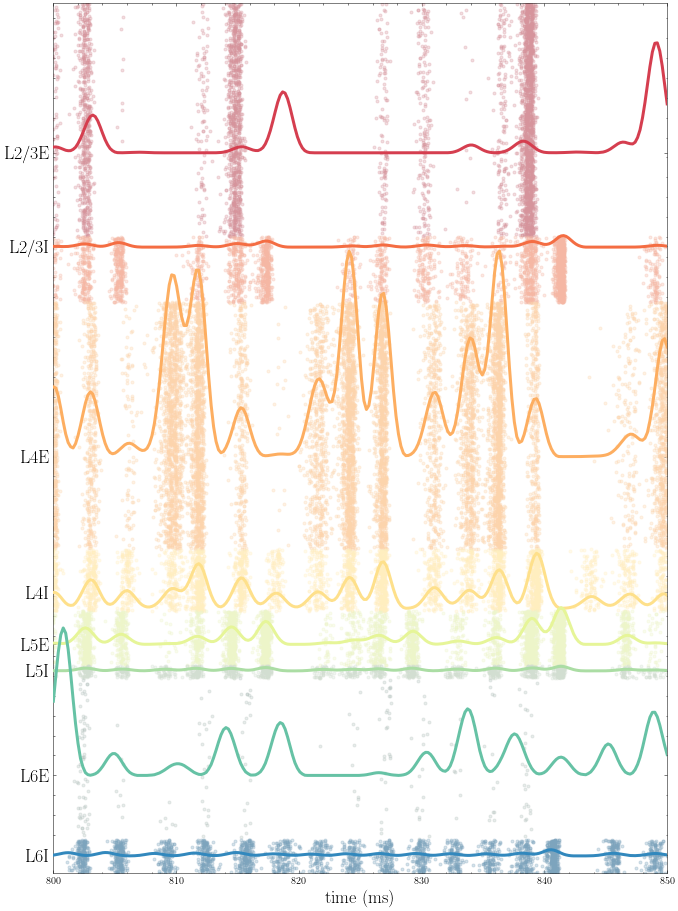

In [8]:
bg_rates = [6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0]
bg_rates = [16]


times_currents = np.linspace(addons.analysis_dict["analysis_start"],addons.analysis_dict["analysis_end"],num=int((addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"])/0.2))

number_of_trials = 1

pop_activities_ini = np.zeros((number_of_trials,len(bg_rates),8,len(times_currents)))
volt_currents_ini= np.zeros((number_of_trials,len(bg_rates),8,1000))
ex_currents_ini= np.zeros((number_of_trials,len(bg_rates),8,1000))
in_currents_ini= np.zeros((number_of_trials,len(bg_rates),8,1000))
lowcut_gamma = 50
highcut_gamma = 95

p0_welsh_gamma = [3000000,80,10]
p0_gamma = [30000,80,5]


p0_welsh = [3000000,10,10]
p0 = [30000,10,5]

fit_lim_low = 1
fit_lim_high = 40
fit_lim_low_gamma = 25
fit_lim_high_gamma = 125
lowcut_alpha = 8
highcut_alpha = 15

stim_time = None


mean_alpha_ini = np.zeros((number_of_trials,8,len(bg_rates)))
mean_gamma_ini = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_alpha_ini = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_gamma_ini = np.zeros((number_of_trials,8,len(bg_rates)))


mean_alpha_final_ini = np.zeros((8,len(bg_rates)))
mean_gamma_final_ini = np.zeros((8,len(bg_rates)))
amplitude_alpha_final_ini = np.zeros((8,len(bg_rates)))
amplitude_gamma_final_ini = np.zeros((8,len(bg_rates)))

dev_mean_alpha_final_ini = np.zeros((8,len(bg_rates)))
dev_mean_gamma_final_ini = np.zeros((8,len(bg_rates)))
dev_amp_alpha_final_ini = np.zeros((8,len(bg_rates)))
dev_amp_gamma_final_ini = np.zeros((8,len(bg_rates)))

for l in range(0,number_of_trials):
    for i in range(len(bg_rates)):
        nest.ResetKernel()
        nest.rng_seed = 1234 + l
        net = network.Network(sim_dict, net_dict, stim_dict, path = "trials_stimulation/",stim_time=stim_time)
        net.create(bg_rate=bg_rates[i],rate='fixed')
        net.connect()

        net.simulate(sim_dict["t_presim"])
        net.simulate(sim_dict["t_sim"])
        raster_plot_interval = np.array([800,850])
        firing_rates_interval = np.array([900,1500])

        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

        name = "trials_stimulation/"
        neuron_id = np.loadtxt(name + "population_nodeids.dat",dtype=int)
        num_neurons = []
        for j in range(len(neuron_id)):
            num_neurons = np.append(num_neurons,int(neuron_id[j][1]-neuron_id[j][0]+1))
        num_neurons = num_neurons.astype(int)

        voltage_data = addons.load_data(name,"voltmeter",)
        time_data = voltage_data[0]["time_ms"][0::num_neurons[0]]
        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
        for j in range(len(num_neurons)):
            data_pop[j] = addons.split_data(voltage_data[j], num_neurons[j])

        del(voltage_data)
        ex_current_data = addons.load_data(name,"ex_current",type="Current")
        for j in range(len(num_neurons)):
            ex_current_pop[j] = addons.split_data(ex_current_data[j],num_neurons[j],type="Current")

        del(ex_current_data)
        in_current_data = addons.load_data(name,"in_current",type="Current")
        for j in range(len(num_neurons)):
            in_current_pop[j] = addons.split_data(in_current_data[j], num_neurons[j],type="Current")
        del(in_current_data)
        volt_currents_ini[l][i], ex_currents_ini[l][i], in_currents_ini[l][i] = prepare_data(data_pop,ex_current_pop,in_current_pop)

        pop_activity, times_a = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True,trial=l,raster=False,M=[15,15,15,15,15,15,15,15],std=[3,3,3,3,3,3,3,3])
        for k in range(len(pop_activity)):
            pop_activities_ini[l][i][k] = pop_activity[k]



    pop_signal_gamma = np.zeros_like(pop_activities_ini[l])



    for i in range(len(pop_activities_ini[l])):
        for j in range(len(pop_activities_ini[l][i])):
            pop_signal_gamma[i][j] = filter_signal(pop_activities_ini[l][i][j],fs=6000,lowcut=lowcut_gamma,highcut=highcut_gamma)

    test_gamma = pop_signal_gamma.transpose(1,0,2)  

    FFT_power_gamma = {}
    Welsh_power_gamma = {}

    sigma_gamma =np.zeros((len(test_gamma),len(bg_rates)))

    for j in range(len(test_gamma)):
        FFT_power_gamma[j], freq, Welsh_freq, Welsh_power_gamma[j], mean_gamma_ini[l][j][:], amplitude_gamma_ini[l][j][:], sigma_gamma[j][:] = compute_FFT(test_gamma[j],save=True,test_p0 = p0_gamma,lim_x=200,plot=False,freq_sample=0.0002,low_log=40,high_log=125,freq_sample_welsh=5000,fit=True,fit_freq_start=fit_lim_low_gamma,fit_freq_end=fit_lim_high_gamma,welsh_fit='gamma',p0=p0_welsh_gamma)


    pop_signal_alpha = np.zeros_like(pop_activities_ini[l])
    #Filter signal
    for i in range(len(pop_activities_ini[l])):
        for j in range(len(pop_activities_ini[l][i])):
            pop_signal_alpha[i][j] = filter_signal(pop_activities_ini[l][i][j],fs=2000,lowcut=lowcut_alpha,highcut=highcut_alpha)


    test_alpha = pop_signal_alpha.transpose(1,0,2)

    FFT_power_alpha = {}
    Welsh_power_alpha = {}

    sigma_alpha =np.zeros((len(test_alpha),len(bg_rates)))


    for j in range(len(test_alpha)):
        FFT_power_alpha[j], freq, Welsh_freq, Welsh_power_alpha[j], mean_alpha_ini[l][j][:], amplitude_alpha_ini[l][j][:], sigma_alpha[j][:] = compute_FFT(test_alpha[j],save=True,fit=True,test_p0 = [300,10,5],lim_x=100,plot=False,fit_freq_start=fit_lim_low,fit_freq_end=fit_lim_high,welsh_fit='alpha',p0=p0_welsh)



    mean_alpha_final_ini = np.mean(mean_alpha_ini,axis=0)
    amplitude_alpha_final_ini = np.mean(amplitude_alpha_ini,axis=0)
    mean_gamma_final_ini = np.mean(mean_gamma_ini,axis=0)
    amplitude_gamma_final_ini = np.mean(amplitude_gamma_ini,axis=0)

    dev_mean_alpha_final_ini = np.std(mean_alpha_ini,axis=0)
    dev_amp_alpha_final_ini = np.std(amplitude_alpha_ini,axis=0)
    dev_mean_gamma_final_ini = np.std(mean_gamma_ini,axis=0)
    dev_amp_gamma_final_ini = np.std(amplitude_gamma_ini,axis=0)

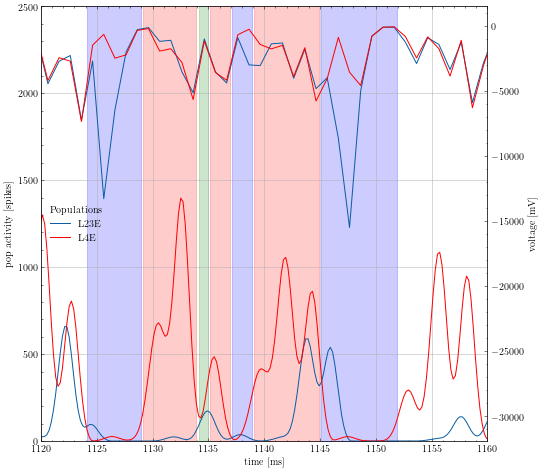

In [9]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_ini[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_ini[0][0][2], label = 'L4E', color='red')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_ini[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_ini[0][0][2], label = 'L4E', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

ax1.fill_between(times_currents,0,2500,where=(times_currents>=1124) & (times_currents<=1129) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,2500,where=(times_currents>=1145) & (times_currents<=1152) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,2500,where=(times_currents>=1129) & (times_currents<=1134) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,2500,where=(times_currents>=1134) & (times_currents<=1135) , color='green', alpha=0.2, label='smallest pause')
ax1.fill_between(times_currents,0,2500,where=(times_currents>=1135) & (times_currents<=1137) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,2500,where=(times_currents>=1137) & (times_currents<=1139) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,2500,where=(times_currents>=1139) & (times_currents<=1145) , color='red', alpha=0.2, label='high burst')

In [10]:
#Analysis for layer 4E, which is the one receiving the pulse

amplitudes_4E_1 = []
delay_1_4E = []
burst_1_4E = []
pause_1_4E = []
burst_2_4E = []
pause_2_4E = []
burst_3_4E = []
pause_3_4E = []


amplitudes_4E_1 = np.append(amplitudes_4E_1,np.max(pop_activities_ini[0][0][2][np.where((times_currents>=1124) & (times_currents<=1160))]))
delay_1_4E = np.append(delay_1_4E,1129-1124)
burst_1_4E = np.append(burst_1_4E,1134 - 1129)
pause_1_4E = np.append(pause_1_4E,1135 - 1134)
burst_2_4E = np.append(burst_2_4E,1137 - 1135)
pause_2_4E = np.append(pause_2_4E,1139-1137)
burst_3_4E = np.append(burst_3_4E,1145 - 1139)
pause_3_4E = np.append(pause_3_4E,1152 - 1145)

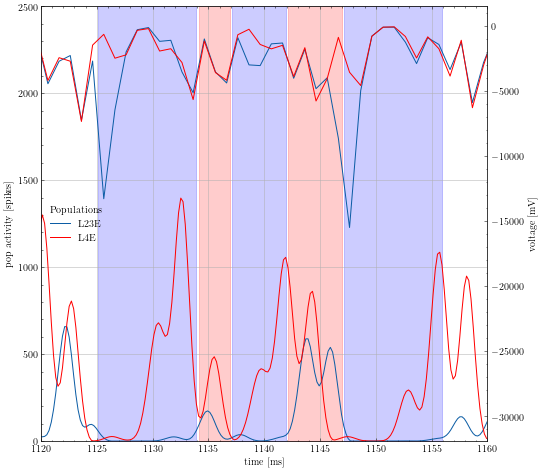

In [11]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_ini[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_ini[0][0][2], label = 'L4E', color='red')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_ini[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_ini[0][0][2], label = 'L4E', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

ax1.fill_between(times_currents,0,2500,where=(times_currents>=1125) & (times_currents<=1134) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,2500,where=(times_currents>=1147) & (times_currents<=1156) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,2500,where=(times_currents>=1134) & (times_currents<=1137) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,2500,where=(times_currents>=1137) & (times_currents<=1142) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,2500,where=(times_currents>=1142) & (times_currents<=1147) , color='red', alpha=0.2, label='high burst')

In [12]:
#Analysis for layer 2E, which is the one receiving the pulse

amplitudes_2E_1 = []
delay_1_2E = []
burst_1_2E = []
pause_1_2E = []
burst_2_2E = []
pause_2_2E = []
burst_3_2E = []
pause_3_2E = []

amplitudes_2E_1 = np.append(amplitudes_2E_1,np.max(pop_activities_ini[0][0][0][np.where((times_currents>=1125) & (times_currents<=1155))]))
delay_1_2E = np.append(delay_1_2E,1134-1125)
burst_1_2E = np.append(burst_1_2E,1137 - 1134)
pause_1_2E = np.append(pause_1_2E,1142 - 1137)
burst_2_2E = np.append(burst_2_2E,1147 - 1142)
pause_2_2E = np.append(pause_2_2E,1156-1147)

(0.0, 2500.0)

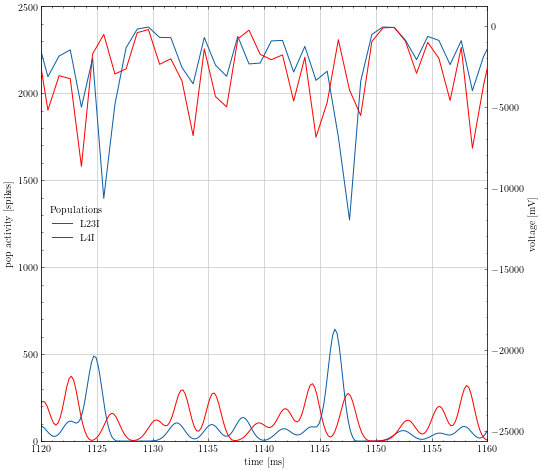

In [13]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_ini[0][0][1], label = 'L23I')
ax1.plot(times_currents,pop_activities_ini[0][0][3], label = 'L4I', color='red')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_ini[0][0][1], label = 'L23I')
ax2.plot(time_volt,in_currents_ini[0][0][3], label = 'L4I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

(0.0, 2500.0)

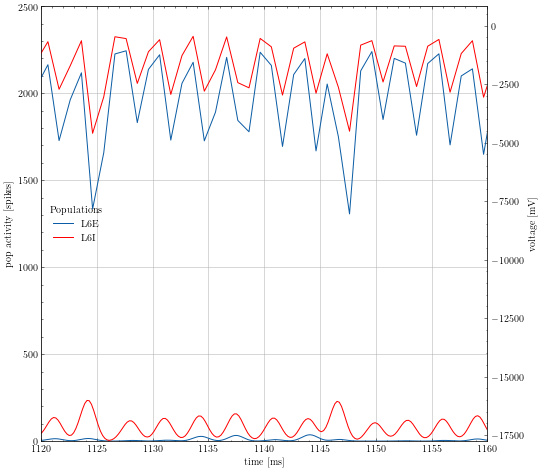

In [14]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_ini[0][0][6], label = 'L6E')
ax1.plot(times_currents,pop_activities_ini[0][0][7], label = 'L6I', color='red')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_ini[0][0][6], label = 'L6E')
ax2.plot(time_volt,in_currents_ini[0][0][7], label = 'L6I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

Data will be written to: trials_stimulation/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 10
Creating neuronal populations.

Jun 12 13:27:30 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating ammeters.
Creating ammeters.
Creating Poisson generators for background input.
Creating external input for external stimulation.
Connecting neuronal populations recurrently.
NodeCollection(metadata=None, model=iaf_psc_exp, size=20683, first=1, last=20683)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5834, first=20684, last=26517)
NodeCollection(metadata=None, model=iaf_psc_exp, size=21915, first=26518, last=48432)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5479, first=48433, last=53911)
NodeCollection(metadata=None, model=iaf_psc_exp, size=4850, first=53912, last=58761)
NodeCollection(meta

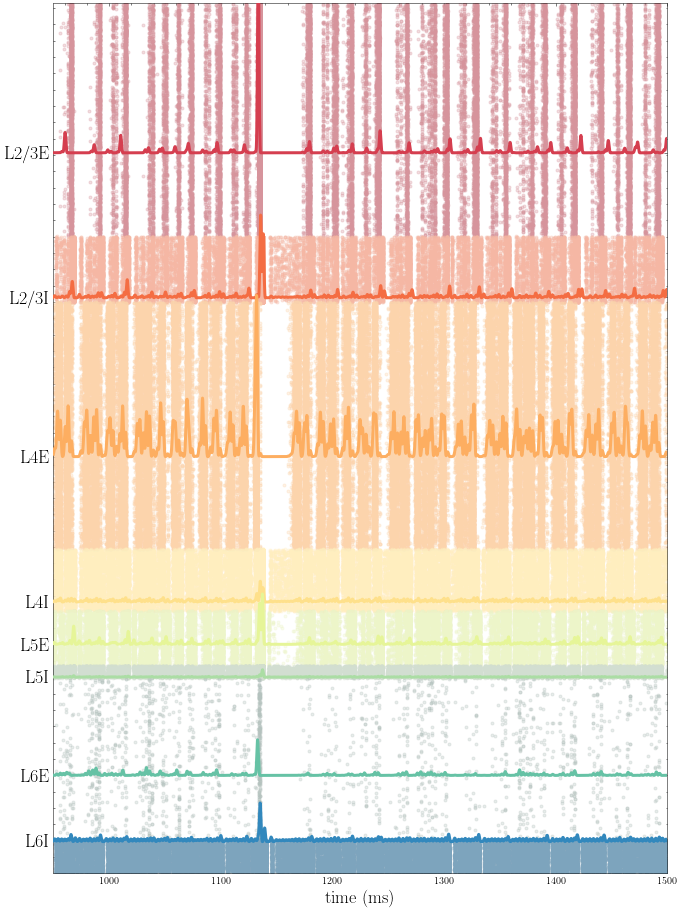

In [15]:
bg_rates = [6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0]
bg_rates = [16.0]


times_currents = np.linspace(addons.analysis_dict["analysis_start"],addons.analysis_dict["analysis_end"],num=int((addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"])/0.2))

number_of_trials = 1

pop_activities_1 = np.zeros((number_of_trials,len(bg_rates),8,len(times_currents)))
volt_currents_1= np.zeros((number_of_trials,len(bg_rates),8,1000))
ex_currents_1= np.zeros((number_of_trials,len(bg_rates),8,1000))
in_currents_1= np.zeros((number_of_trials,len(bg_rates),8,1000))
lowcut_gamma = 50
highcut_gamma = 95

p0_welsh_gamma = [3000000,80,10]
p0_gamma = [30000,80,5]


p0_welsh = [3000000,10,10]
p0 = [30000,10,5]

fit_lim_low = 1
fit_lim_high = 40
fit_lim_low_gamma = 25
fit_lim_high_gamma = 125
lowcut_alpha = 8
highcut_alpha = 15

stim_time = 1130

mean_alpha_1 = np.zeros((number_of_trials,8,len(bg_rates)))
mean_gamma_1 = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_alpha_1 = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_gamma_1 = np.zeros((number_of_trials,8,len(bg_rates)))

for l in range(0,number_of_trials):
    for i in range(len(bg_rates)):
        nest.ResetKernel()
        nest.rng_seed = 1234 + l
        net = network.Network(sim_dict, net_dict, stim_dict, path = "trials_stimulation/",stim_time=stim_time)
        net.create(bg_rate=bg_rates[i],rate='fixed')
        net.connect()

        net.simulate(sim_dict["t_presim"])
        net.simulate(sim_dict["t_sim"])
        raster_plot_interval = np.array([950, 1500])
        firing_rates_interval = np.array([900,1450])

        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

        name = "trials_stimulation/"
        neuron_id = np.loadtxt(name + "population_nodeids.dat",dtype=int)
        num_neurons = []
        for j in range(len(neuron_id)):
            num_neurons = np.append(num_neurons,int(neuron_id[j][1]-neuron_id[j][0]+1))
        num_neurons = num_neurons.astype(int)

        voltage_data = addons.load_data(name,"voltmeter",)
        time_data = voltage_data[0]["time_ms"][0::num_neurons[0]]
        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
        for j in range(len(num_neurons)):
            data_pop[j] = addons.split_data(voltage_data[j], num_neurons[j])

        del(voltage_data)
        ex_current_data = addons.load_data(name,"ex_current",type="Current")
        for j in range(len(num_neurons)):
            ex_current_pop[j] = addons.split_data(ex_current_data[j],num_neurons[j],type="Current")

        del(ex_current_data)
        in_current_data = addons.load_data(name,"in_current",type="Current")
        for j in range(len(num_neurons)):
            in_current_pop[j] = addons.split_data(in_current_data[j], num_neurons[j],type="Current")
        del(in_current_data)
        volt_currents_1[l][i], ex_currents_1[l][i], in_currents_1[l][i] = prepare_data(data_pop,ex_current_pop,in_current_pop)

        pop_activity, times_a = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True,trial=l,raster=False,M=[15,15,15,15,15,15,15,15],std=[3,3,3,3,3,3,3,3])
        for k in range(len(pop_activity)):
            pop_activities_1[l][i][k] = pop_activity[k]



    pop_signal_gamma = np.zeros_like(pop_activities_1[l])



    for i in range(len(pop_activities_1[l])):
        for j in range(len(pop_activities_1[l][i])):
            pop_signal_gamma[i][j] = filter_signal(pop_activities_1[l][i][j],fs=6000,lowcut=lowcut_gamma,highcut=highcut_gamma)

    test_gamma = pop_signal_gamma.transpose(1,0,2)  

    FFT_power_gamma = {}
    Welsh_power_gamma = {}

    sigma_gamma =np.zeros((len(test_gamma),len(bg_rates)))

    for j in range(len(test_gamma)):
        FFT_power_gamma[j], freq, Welsh_freq, Welsh_power_gamma[j], mean_gamma_1[l][j][:], amplitude_gamma_1[l][j][:], sigma_gamma[j][:] = compute_FFT(test_gamma[j],save=True,test_p0 = p0_gamma,lim_x=200,plot=False,freq_sample=0.0002,low_log=40,high_log=125,freq_sample_welsh=5000,fit=True,fit_freq_start=fit_lim_low_gamma,fit_freq_end=fit_lim_high_gamma,welsh_fit='gamma',p0=p0_welsh_gamma)


    pop_signal_alpha = np.zeros_like(pop_activities_1[l])
    #Filter signal
    for i in range(len(pop_activities_1[l])):
        for j in range(len(pop_activities_1[l][i])):
            pop_signal_alpha[i][j] = filter_signal(pop_activities_1[l][i][j],fs=2000,lowcut=lowcut_alpha,highcut=highcut_alpha)


    test_alpha = pop_signal_alpha.transpose(1,0,2)

    FFT_power_alpha = {}
    Welsh_power_alpha = {}

    sigma_alpha =np.zeros((len(test_alpha),len(bg_rates)))


    for j in range(len(test_alpha)):
        FFT_power_alpha[j], freq, Welsh_freq, Welsh_power_alpha[j], mean_alpha_1[l][j][:], amplitude_alpha_1[l][j][:], sigma_alpha[j][:] = compute_FFT(test_alpha[j],save=True,fit=True,test_p0 = [300,10,5],lim_x=100,plot=False,fit_freq_start=fit_lim_low,fit_freq_end=fit_lim_high,welsh_fit='alpha',p0=p0_welsh)



    mean_alpha_final = np.mean(mean_alpha_1,axis=0)
    amplitude_alpha_final = np.mean(amplitude_alpha_1,axis=0)
    mean_gamma_final = np.mean(mean_gamma_1,axis=0)
    amplitude_gamma_final = np.mean(amplitude_gamma_1,axis=0)

    dev_mean_alpha_final = np.std(mean_alpha_1,axis=0)
    dev_amp_alpha_final = np.std(amplitude_alpha_1,axis=0)
    dev_mean_gamma_final = np.std(mean_gamma_1,axis=0)
    dev_amp_gamma_final = np.std(amplitude_gamma_1,axis=0)

(0.0, 4600.0)

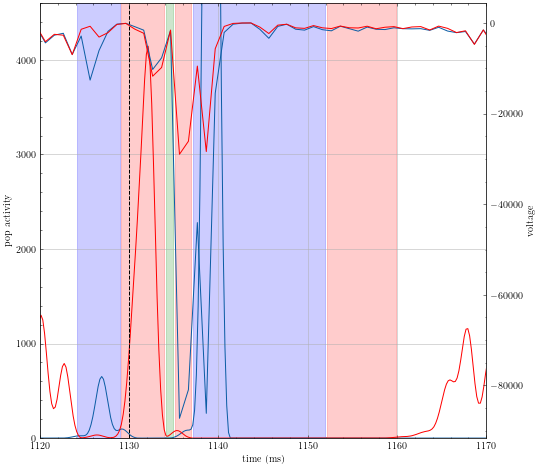

In [16]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('pop activity')
ax1.set_xlim(1120,1170)
 
ax1.plot(times_currents,pop_activities_1[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_1[0][0][2], label = 'L4E', color='red')
ax1.axvline(x=1130, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_1[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_1[0][0][2], label = 'L4E', color='red')


ax1.fill_between(times_currents,0,4600,where=(times_currents>=1124) & (times_currents<=1129) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,4600,where=(times_currents>=1129) & (times_currents<=1134) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4600,where=(times_currents>=1134) & (times_currents<=1135) , color='green', alpha=0.2, label='smallest pause')
ax1.fill_between(times_currents,0,4600,where=(times_currents>=1135) & (times_currents<=1137) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4600,where=(times_currents>=1137) & (times_currents<=1152) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,4600,where=(times_currents>=1152) & (times_currents<=1160) , color='red', alpha=0.2, label='high burst')
ax1.grid()
ax1.set_ylim(0,4600)


In [17]:
#Analysis for layer 4E, which is the one receiving the pulse

amplitudes_4E_1 = np.append(amplitudes_4E_1,np.max(pop_activities_1[0][0][2][np.where((times_currents>=1124) & (times_currents<=1160))]))
delay_1_4E = np.append(delay_1_4E,1129-1124)
burst_1_4E = np.append(burst_1_4E,1134 - 1129)
pause_1_4E = np.append(pause_1_4E,1135 - 1134)
burst_2_4E = np.append(burst_2_4E,1137 - 1135)
pause_2_4E = np.append(pause_2_4E,1152-1137)
pause_3_4E = np.append(pause_3_4E,1160 - 1152)

(0.0, 4600.0)

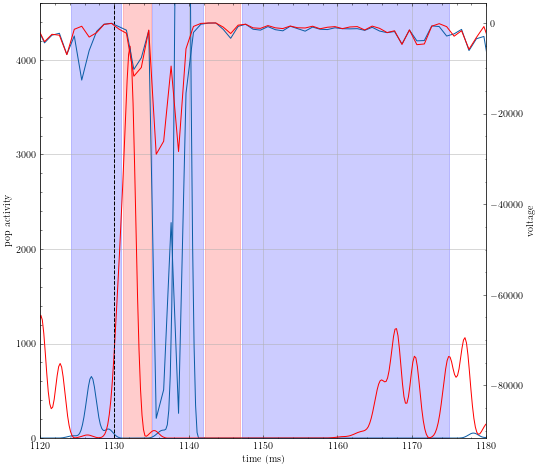

: 

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('pop activity')
ax1.set_xlim(1120,1180)
 
ax1.plot(times_currents,pop_activities_1[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_1[0][0][2], label = 'L4E', color='red')
ax1.axvline(x=1130, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_1[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_1[0][0][2], label = 'L4E', color='red')


ax1.fill_between(times_currents,0,4600,where=(times_currents>=1124) & (times_currents<=1131) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,4600,where=(times_currents>=1131) & (times_currents<=1135) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4600,where=(times_currents>=1135) & (times_currents<=1142) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,4600,where=(times_currents>=1142) & (times_currents<=1147) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4600,where=(times_currents>=1147) & (times_currents<=1175) , color='blue', alpha=0.2, label='small pause')
ax1.grid()
ax1.set_ylim(0,4600)

In [19]:
amplitudes_2E_1 = np.append(amplitudes_2E_1,np.max(pop_activities_1[0][0][0][np.where((times_currents>=1125) & (times_currents<=1155))]))
delay_1_2E = np.append(delay_1_2E,1131-1125)
burst_1_2E = np.append(burst_1_2E,1135 - 1131)
pause_1_2E = np.append(pause_1_2E,1142 - 1135)
burst_2_2E = np.append(burst_2_2E,1147 - 1142)
pause_2_2E = np.append(pause_2_2E,1175-1147)

(0.0, 2500.0)

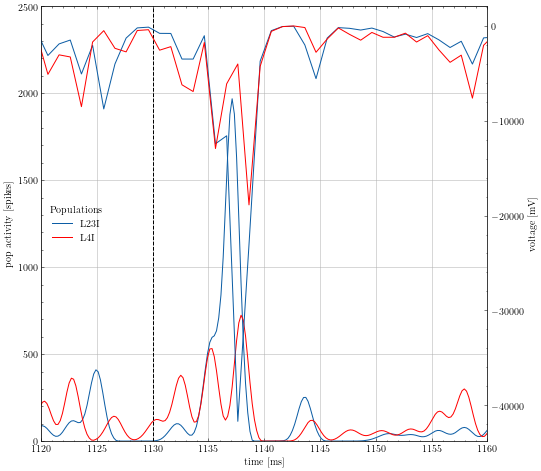

In [20]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_1[0][0][1], label = 'L23I')
ax1.plot(times_currents,pop_activities_1[0][0][3], label = 'L4I', color='red')
ax1.axvline(x=1130, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_1[0][0][1], label = 'L23I')
ax2.plot(time_volt,in_currents_1[0][0][3], label = 'L4I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

(0.0, 2500.0)

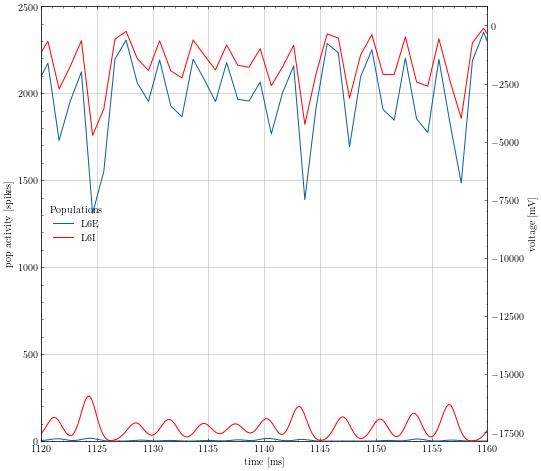

In [21]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_1[0][0][6], label = 'L6E')
ax1.plot(times_currents,pop_activities_1[0][0][7], label = 'L6I', color='red')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_1[0][0][6], label = 'L6E')
ax2.plot(time_volt,in_currents_1[0][0][7], label = 'L6I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

Data will be written to: trials_stimulation/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 10
Creating neuronal populations.

Jun 04 11:27:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating ammeters.
Creating ammeters.
Creating Poisson generators for background input.
Creating external input for external stimulation.
Connecting neuronal populations recurrently.
NodeCollection(metadata=None, model=iaf_psc_exp, size=20683, first=1, last=20683)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5834, first=20684, last=26517)
NodeCollection(metadata=None, model=iaf_psc_exp, size=21915, first=26518, last=48432)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5479, first=48433, last=53911)
NodeCollection(metadata=None, model=iaf_psc_exp, size=4850, first=53912, last=58761)
NodeCollection(meta

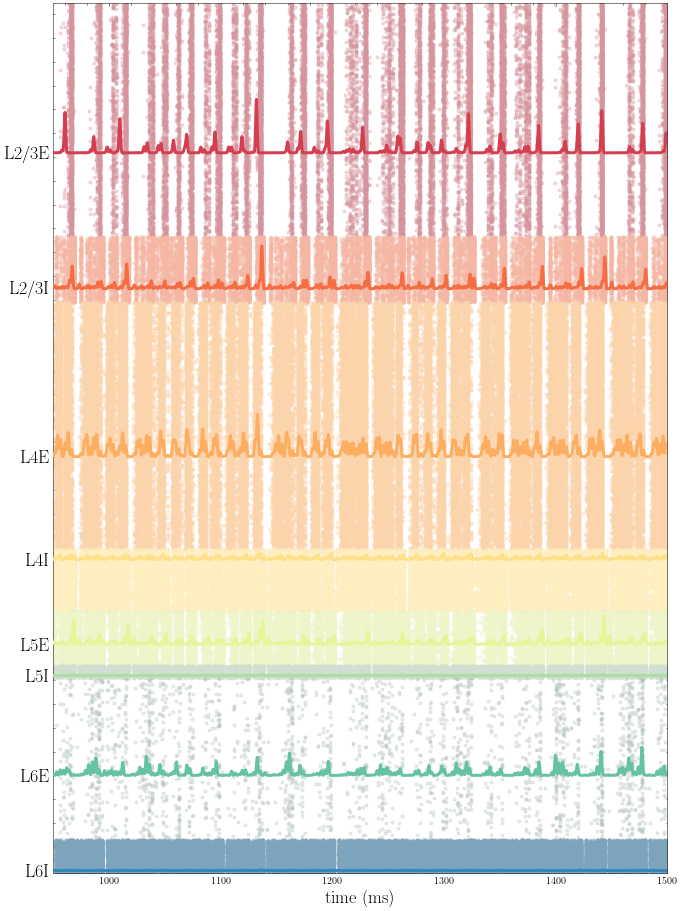

In [14]:
bg_rates = [6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0]
bg_rates = [16.0]


times_currents = np.linspace(addons.analysis_dict["analysis_start"],addons.analysis_dict["analysis_end"],num=int((addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"])/0.2))

number_of_trials = 1

pop_activities_2 = np.zeros((number_of_trials,len(bg_rates),8,len(times_currents)))
volt_currents_2= np.zeros((number_of_trials,len(bg_rates),8,1000))
ex_currents_2= np.zeros((number_of_trials,len(bg_rates),8,1000))
in_currents_2= np.zeros((number_of_trials,len(bg_rates),8,1000))
lowcut_gamma = 50
highcut_gamma = 95

p0_welsh_gamma = [3000000,80,10]
p0_gamma = [30000,80,5]


p0_welsh = [3000000,10,10]
p0 = [30000,10,5]

fit_lim_low = 1
fit_lim_high = 40
fit_lim_low_gamma = 25
fit_lim_high_gamma = 125
lowcut_alpha = 8
highcut_alpha = 15

stim_time = 1131

mean_alpha_2 = np.zeros((number_of_trials,8,len(bg_rates)))
mean_gamma_2 = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_alpha_2 = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_gamma_2 = np.zeros((number_of_trials,8,len(bg_rates)))

for l in range(0,number_of_trials):
    for i in range(len(bg_rates)):
        nest.ResetKernel()
        nest.rng_seed = 1234 + l
        net = network.Network(sim_dict, net_dict, stim_dict, path = "trials_stimulation/",stim_time=stim_time)
        net.create(bg_rate=bg_rates[i],rate='fixed')
        net.connect()

        net.simulate(sim_dict["t_presim"])
        net.simulate(sim_dict["t_sim"])
        raster_plot_interval = np.array([950, 1500])
        firing_rates_interval = np.array([900,1450])

        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

        name = "trials_stimulation/"
        neuron_id = np.loadtxt(name + "population_nodeids.dat",dtype=int)
        num_neurons = []
        for j in range(len(neuron_id)):
            num_neurons = np.append(num_neurons,int(neuron_id[j][1]-neuron_id[j][0]+1))
        num_neurons = num_neurons.astype(int)

        voltage_data = addons.load_data(name,"voltmeter",)
        time_data = voltage_data[0]["time_ms"][0::num_neurons[0]]
        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
        for j in range(len(num_neurons)):
            data_pop[j] = addons.split_data(voltage_data[j], num_neurons[j])

        del(voltage_data)
        ex_current_data = addons.load_data(name,"ex_current",type="Current")
        for j in range(len(num_neurons)):
            ex_current_pop[j] = addons.split_data(ex_current_data[j],num_neurons[j],type="Current")

        del(ex_current_data)
        in_current_data = addons.load_data(name,"in_current",type="Current")
        for j in range(len(num_neurons)):
            in_current_pop[j] = addons.split_data(in_current_data[j], num_neurons[j],type="Current")
        del(in_current_data)
        volt_currents_2[l][i], ex_currents_2[l][i], in_currents_2[l][i] = prepare_data(data_pop,ex_current_pop,in_current_pop)

        pop_activity, times_a = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True,trial=l,raster=False,M=[15,15,15,15,15,15,15,15],std=[3,3,3,3,3,3,3,3])
        for k in range(len(pop_activity)):
            pop_activities_2[l][i][k] = pop_activity[k]



    pop_signal_gamma = np.zeros_like(pop_activities_2[l])



    for i in range(len(pop_activities_2[l])):
        for j in range(len(pop_activities_2[l][i])):
            pop_signal_gamma[i][j] = filter_signal(pop_activities_2[l][i][j],fs=6000,lowcut=lowcut_gamma,highcut=highcut_gamma)

    test_gamma = pop_signal_gamma.transpose(1,0,2)  

    FFT_power_gamma = {}
    Welsh_power_gamma = {}

    sigma_gamma =np.zeros((len(test_gamma),len(bg_rates)))

    for j in range(len(test_gamma)):
        FFT_power_gamma[j], freq, Welsh_freq, Welsh_power_gamma[j], mean_gamma_2[l][j][:], amplitude_gamma_2[l][j][:], sigma_gamma[j][:] = compute_FFT(test_gamma[j],save=True,test_p0 = p0_gamma,lim_x=200,plot=False,freq_sample=0.0002,low_log=40,high_log=125,freq_sample_welsh=5000,fit=True,fit_freq_start=fit_lim_low_gamma,fit_freq_end=fit_lim_high_gamma,welsh_fit='gamma',p0=p0_welsh_gamma)


    pop_signal_alpha = np.zeros_like(pop_activities_2[l])
    #Filter signal
    for i in range(len(pop_activities_2[l])):
        for j in range(len(pop_activities_2[l][i])):
            pop_signal_alpha[i][j] = filter_signal(pop_activities_2[l][i][j],fs=2000,lowcut=lowcut_alpha,highcut=highcut_alpha)


    test_alpha = pop_signal_alpha.transpose(1,0,2)

    FFT_power_alpha = {}
    Welsh_power_alpha = {}

    sigma_alpha =np.zeros((len(test_alpha),len(bg_rates)))


    for j in range(len(test_alpha)):
        FFT_power_alpha[j], freq, Welsh_freq, Welsh_power_alpha[j], mean_alpha_2[l][j][:], amplitude_alpha_2[l][j][:], sigma_alpha[j][:] = compute_FFT(test_alpha[j],save=True,fit=True,test_p0 = [300,10,5],lim_x=100,plot=False,fit_freq_start=fit_lim_low,fit_freq_end=fit_lim_high,welsh_fit='alpha',p0=p0_welsh)



    mean_alpha_final = np.mean(mean_alpha_2,axis=0)
    amplitude_alpha_final = np.mean(amplitude_alpha_2,axis=0)
    mean_gamma_final = np.mean(mean_gamma_2,axis=0)
    amplitude_gamma_final = np.mean(amplitude_gamma_2,axis=0)

    dev_mean_alpha_final = np.std(mean_alpha_2,axis=0)
    dev_amp_alpha_final = np.std(amplitude_alpha_2,axis=0)
    dev_mean_gamma_final = np.std(mean_gamma_2,axis=0)
    dev_amp_gamma_final = np.std(amplitude_gamma_2,axis=0)

(0.0, 2500.0)

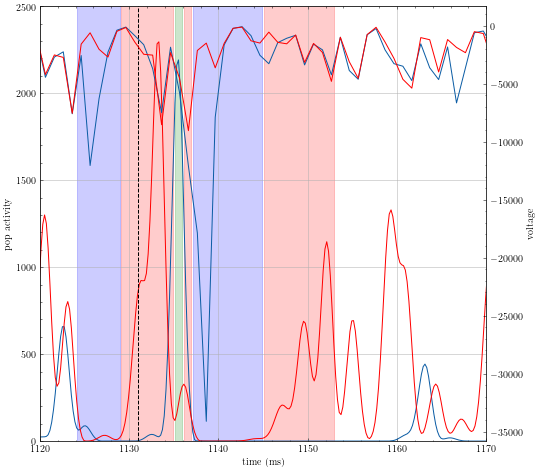

In [15]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('pop activity')
ax1.set_xlim(1120,1170)
 
ax1.plot(times_currents,pop_activities_2[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_2[0][0][2], label = 'L4E', color='red')
ax1.axvline(x=stim_time, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_2[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_2[0][0][2], label = 'L4E', color='red')


ax1.fill_between(times_currents,0,4000,where=(times_currents>=1124) & (times_currents<=1129) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1129) & (times_currents<=1135) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1135) & (times_currents<=1136) , color='green', alpha=0.2, label='smallest pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1136) & (times_currents<=1137) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1137) & (times_currents<=1145) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1145) & (times_currents<=1153) , color='red', alpha=0.2, label='high burst')
ax1.grid()
ax1.set_ylim(0,2500)


In [57]:
#Analysis for layer 4E, which is the one receiving the pulse
amplitudes_4E_1 = np.append(amplitudes_4E_1, np.max(pop_activities_2[0][0][2][np.where((times_currents>=1124) & (times_currents<=1160))]))
delay_1_4E = np.append(delay_1_4E,1129-1124)
burst_1_4E = np.append(burst_1_4E,1135 - 1129)
pause_1_4E = np.append(pause_1_4E,1136 - 1135)
burst_2_4E = np.append(burst_2_4E,1137 - 1136)
pause_2_4E = np.append(pause_2_4E,1145-1137)
pause_3_4E = np.append(pause_3_4E,1153 - 1145)

(0.0, 2500.0)

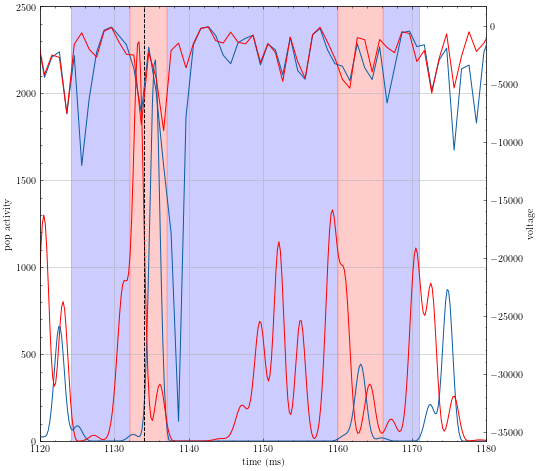

In [54]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('pop activity')
ax1.set_xlim(1120,1180)
 
ax1.plot(times_currents,pop_activities_2[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_2[0][0][2], label = 'L4E', color='red')
ax1.axvline(x=stim_time, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_2[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_2[0][0][2], label = 'L4E', color='red')


ax1.fill_between(times_currents,0,4000,where=(times_currents>=1124) & (times_currents<=1132) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1132) & (times_currents<=1137) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1137) & (times_currents<=1160) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1160) & (times_currents<=1166) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1166) & (times_currents<=1171) , color='blue', alpha=0.2, label='small pause')
ax1.grid()
ax1.set_ylim(0,2500)


In [58]:

amplitudes_2E_1 = np.append(amplitudes_2E_1,np.max(pop_activities_2[0][0][0][np.where((times_currents>=1125) & (times_currents<=1155))]))
delay_1_2E = np.append(delay_1_2E,1132-1124)
burst_1_2E = np.append(burst_1_2E,1137 - 1132)
pause_1_2E = np.append(pause_1_2E,1160 - 1137)
burst_2_2E = np.append(burst_2_2E,1166 - 1160)
pause_2_2E = np.append(pause_2_2E,1166-1171)

(0.0, 2500.0)

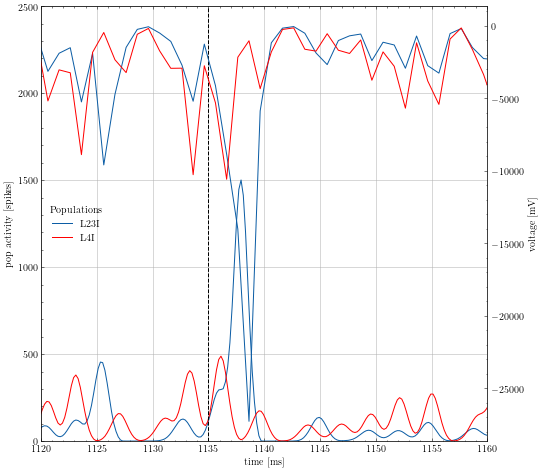

In [80]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_2[0][0][1], label = 'L23I')
ax1.plot(times_currents,pop_activities_2[0][0][3], label = 'L4I', color='red')
ax1.axvline(x=1135, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_2[0][0][1], label = 'L23I')
ax2.plot(time_volt,in_currents_2[0][0][3], label = 'L4I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

(0.0, 2500.0)

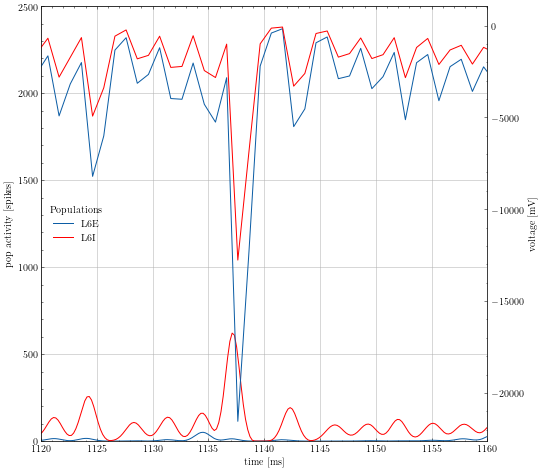

In [88]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_2[0][0][6], label = 'L6E')
ax1.plot(times_currents,pop_activities_2[0][0][7], label = 'L6I', color='red')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_2[0][0][6], label = 'L6E')
ax2.plot(time_volt,in_currents_2[0][0][7], label = 'L6I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

Data will be written to: trials_stimulation/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 10
Creating neuronal populations.

Jun 04 11:36:36 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating ammeters.
Creating ammeters.
Creating Poisson generators for background input.
Creating external input for external stimulation.
Connecting neuronal populations recurrently.
NodeCollection(metadata=None, model=iaf_psc_exp, size=20683, first=1, last=20683)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5834, first=20684, last=26517)
NodeCollection(metadata=None, model=iaf_psc_exp, size=21915, first=26518, last=48432)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5479, first=48433, last=53911)
NodeCollection(metadata=None, model=iaf_psc_exp, size=4850, first=53912, last=58761)
NodeCollection(meta

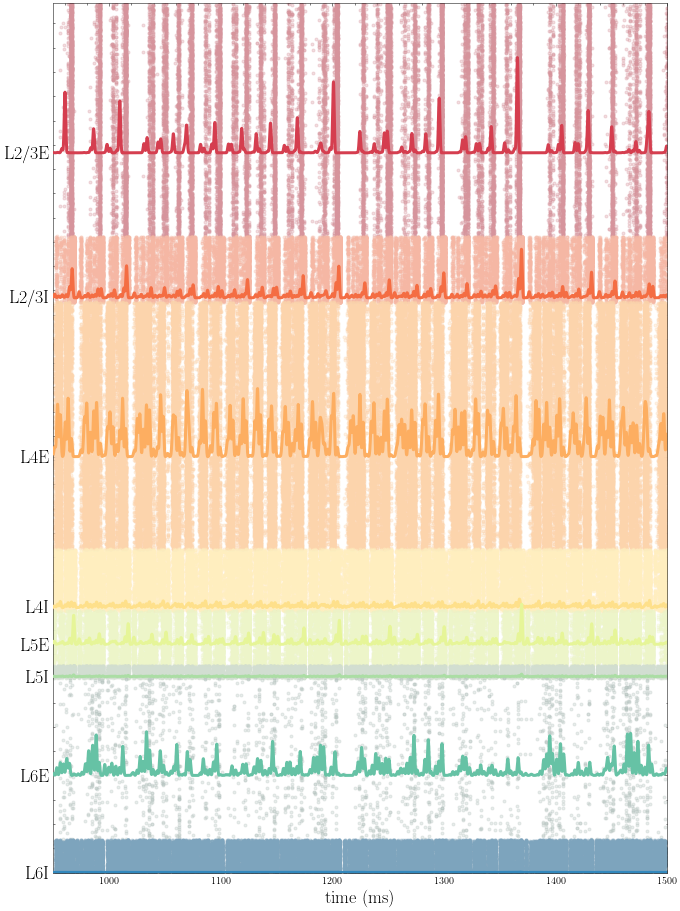

In [17]:
bg_rates = [6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0]
bg_rates = [16.0]


times_currents = np.linspace(addons.analysis_dict["analysis_start"],addons.analysis_dict["analysis_end"],num=int((addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"])/0.2))

number_of_trials = 1

pop_activities_3 = np.zeros((number_of_trials,len(bg_rates),8,len(times_currents)))
volt_currents_3= np.zeros((number_of_trials,len(bg_rates),8,1000))
ex_currents_3 = np.zeros((number_of_trials,len(bg_rates),8,1000))
in_currents_3 = np.zeros((number_of_trials,len(bg_rates),8,1000))
lowcut_gamma = 50
highcut_gamma = 95

p0_welsh_gamma = [3000000,80,10]
p0_gamma = [30000,80,5]


p0_welsh = [3000000,10,10]
p0 = [30000,10,5]

fit_lim_low = 1
fit_lim_high = 40
fit_lim_low_gamma = 25
fit_lim_high_gamma = 125
lowcut_alpha = 8
highcut_alpha = 15

stim_time = 1132

mean_alpha_3 = np.zeros((number_of_trials,8,len(bg_rates)))
mean_gamma_3 = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_alpha_3 = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_gamma_3 = np.zeros((number_of_trials,8,len(bg_rates)))

for l in range(0,number_of_trials):
    for i in range(len(bg_rates)):
        nest.ResetKernel()
        nest.rng_seed = 1234 + l
        net = network.Network(sim_dict, net_dict, stim_dict, path = "trials_stimulation/",stim_time=stim_time)
        net.create(bg_rate=bg_rates[i],rate='fixed')
        net.connect()

        net.simulate(sim_dict["t_presim"])
        net.simulate(sim_dict["t_sim"])
        raster_plot_interval = np.array([950, 1500])
        firing_rates_interval = np.array([900,1450])

        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

        name = "trials_stimulation/"
        neuron_id = np.loadtxt(name + "population_nodeids.dat",dtype=int)
        num_neurons = []
        for j in range(len(neuron_id)):
            num_neurons = np.append(num_neurons,int(neuron_id[j][1]-neuron_id[j][0]+1))
        num_neurons = num_neurons.astype(int)

        voltage_data = addons.load_data(name,"voltmeter",)
        time_data = voltage_data[0]["time_ms"][0::num_neurons[0]]
        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
        for j in range(len(num_neurons)):
            data_pop[j] = addons.split_data(voltage_data[j], num_neurons[j])

        del(voltage_data)
        ex_current_data = addons.load_data(name,"ex_current",type="Current")
        for j in range(len(num_neurons)):
            ex_current_pop[j] = addons.split_data(ex_current_data[j],num_neurons[j],type="Current")

        del(ex_current_data)
        in_current_data = addons.load_data(name,"in_current",type="Current")
        for j in range(len(num_neurons)):
            in_current_pop[j] = addons.split_data(in_current_data[j], num_neurons[j],type="Current")
        del(in_current_data)
        volt_currents_3[l][i], ex_currents_3[l][i], in_currents_3[l][i] = prepare_data(data_pop,ex_current_pop,in_current_pop)

        pop_activity, times_a = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True,trial=l,raster=False,M=[15,15,15,15,15,15,15,15],std=[3,3,3,3,3,3,3,3])
        for k in range(len(pop_activity)):
            pop_activities_3[l][i][k] = pop_activity[k]



    pop_signal_gamma = np.zeros_like(pop_activities_3[l])



    for i in range(len(pop_activities_3[l])):
        for j in range(len(pop_activities_3[l][i])):
            pop_signal_gamma[i][j] = filter_signal(pop_activities_3[l][i][j],fs=6000,lowcut=lowcut_gamma,highcut=highcut_gamma)

    test_gamma = pop_signal_gamma.transpose(1,0,2)  

    FFT_power_gamma = {}
    Welsh_power_gamma = {}

    sigma_gamma =np.zeros((len(test_gamma),len(bg_rates)))

    for j in range(len(test_gamma)):
        FFT_power_gamma[j], freq, Welsh_freq, Welsh_power_gamma[j], mean_gamma_3[l][j][:], amplitude_gamma_3[l][j][:], sigma_gamma[j][:] = compute_FFT(test_gamma[j],save=True,test_p0 = p0_gamma,lim_x=200,plot=False,freq_sample=0.0002,low_log=40,high_log=125,freq_sample_welsh=5000,fit=True,fit_freq_start=fit_lim_low_gamma,fit_freq_end=fit_lim_high_gamma,welsh_fit='gamma',p0=p0_welsh_gamma)


    pop_signal_alpha = np.zeros_like(pop_activities_3[l])
    #Filter signal
    for i in range(len(pop_activities_3[l])):
        for j in range(len(pop_activities_3[l][i])):
            pop_signal_alpha[i][j] = filter_signal(pop_activities_3[l][i][j],fs=2000,lowcut=lowcut_alpha,highcut=highcut_alpha)


    test_alpha = pop_signal_alpha.transpose(1,0,2)

    FFT_power_alpha = {}
    Welsh_power_alpha = {}

    sigma_alpha =np.zeros((len(test_alpha),len(bg_rates)))


    for j in range(len(test_alpha)):
        FFT_power_alpha[j], freq, Welsh_freq, Welsh_power_alpha[j], mean_alpha_3[l][j][:], amplitude_alpha_3[l][j][:], sigma_alpha[j][:] = compute_FFT(test_alpha[j],save=True,fit=True,test_p0 = [300,10,5],lim_x=100,plot=False,fit_freq_start=fit_lim_low,fit_freq_end=fit_lim_high,welsh_fit='alpha',p0=p0_welsh)



    mean_alpha_final = np.mean(mean_alpha_3,axis=0)
    amplitude_alpha_final = np.mean(amplitude_alpha_3,axis=0)
    mean_gamma_final = np.mean(mean_gamma_3,axis=0)
    amplitude_gamma_final = np.mean(amplitude_gamma_3,axis=0)

    dev_mean_alpha_final = np.std(mean_alpha_3,axis=0)
    dev_amp_alpha_final = np.std(amplitude_alpha_3,axis=0)
    dev_mean_gamma_final = np.std(mean_gamma_3,axis=0)
    dev_amp_gamma_final = np.std(amplitude_gamma_3,axis=0)

(0.0, 2500.0)

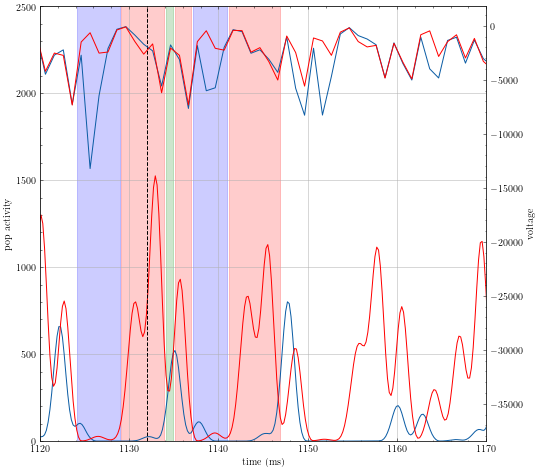

In [18]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('pop activity')
ax1.set_xlim(1120,1170)
 
ax1.plot(times_currents,pop_activities_3[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_3[0][0][2], label = 'L4E', color='red')
ax1.axvline(x=stim_time, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_3[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_3[0][0][2], label = 'L4E', color='red')


ax1.fill_between(times_currents,0,4000,where=(times_currents>=1124) & (times_currents<=1129) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1129) & (times_currents<=1134) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1134) & (times_currents<=1135) , color='green', alpha=0.2, label='smallest pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1135) & (times_currents<=1137) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1137) & (times_currents<=1141) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1141) & (times_currents<=1147) , color='red', alpha=0.2, label='high burst')
ax1.grid()
ax1.set_ylim(0,2500)


In [19]:
#Analysis for layer 4E, which is the one receiving the pulse
amplitudes_4E_1 = np.append(amplitudes_4E_1,  np.max(pop_activities_3[0][0][2][np.where((times_currents>=1124) & (times_currents<=1160))]))
delay_1_4E = np.append(delay_1_4E,1129-1124)
burst_1_4E = np.append(burst_1_4E,1134 - 1129)
pause_1_4E = np.append(pause_1_4E,1135 - 1134)
burst_2_4E = np.append(burst_2_4E,1137 - 1135)
pause_2_4E = np.append(pause_2_4E,1141-1137)
pause_3_4E = np.append(pause_3_4E,1147 - 1141)

(0.0, 2500.0)

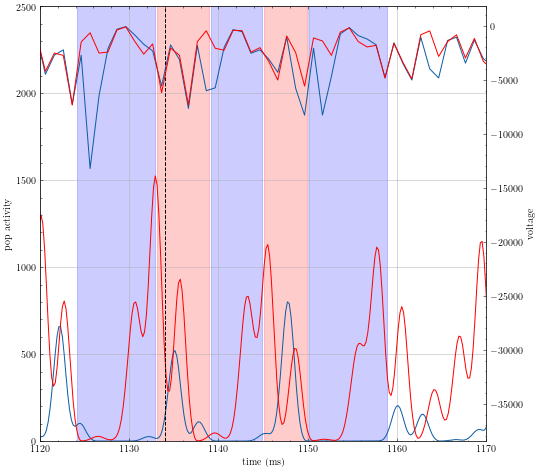

In [62]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('pop activity')
ax1.set_xlim(1120,1170)
 
ax1.plot(times_currents,pop_activities_3[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_3[0][0][2], label = 'L4E', color='red')
ax1.axvline(x=stim_time, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_3[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_3[0][0][2], label = 'L4E', color='red')


ax1.fill_between(times_currents,0,4000,where=(times_currents>=1124) & (times_currents<=1133) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1133) & (times_currents<=1139) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1139) & (times_currents<=1145) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1145) & (times_currents<=1150) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1150) & (times_currents<=1159) , color='blue', alpha=0.2, label='small pause')
ax1.grid()
ax1.set_ylim(0,2500)


In [63]:

amplitudes_2E_1 = np.append(amplitudes_2E_1,np.max(pop_activities_3[0][0][0][np.where((times_currents>=1125) & (times_currents<=1155))]))
delay_1_2E = np.append(delay_1_2E,1133-1124)
burst_1_2E = np.append(burst_1_2E,1139 - 1133)
pause_1_2E = np.append(pause_1_2E,1145 - 1139)
burst_2_2E = np.append(burst_2_2E,1150 - 1145)
pause_2_2E = np.append(pause_2_2E,1159-1150)

(0.0, 2500.0)

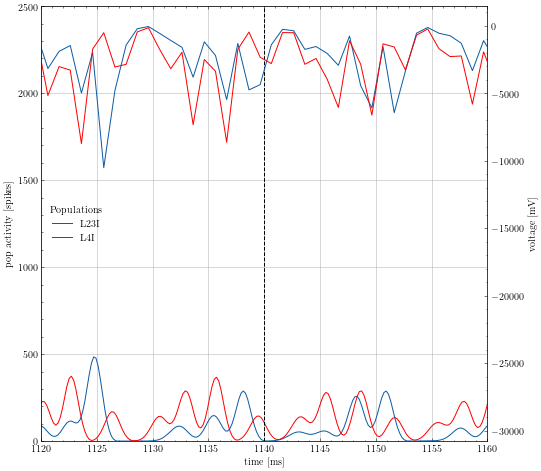

In [81]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_3[0][0][1], label = 'L23I')
ax1.plot(times_currents,pop_activities_3[0][0][3], label = 'L4I', color='red')
ax1.axvline(x=1140, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_3[0][0][1], label = 'L23I')
ax2.plot(time_volt,in_currents_3[0][0][3], label = 'L4I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

(0.0, 2500.0)

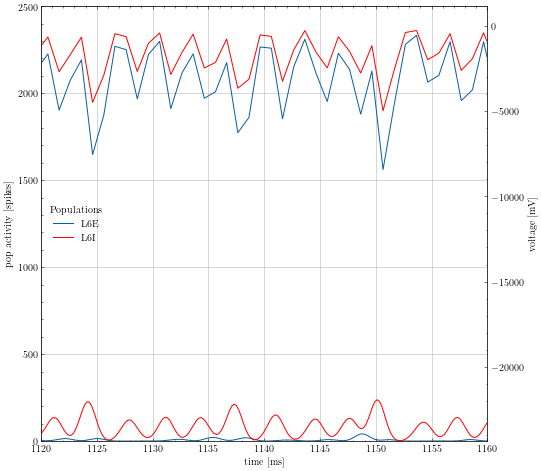

In [89]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_3[0][0][6], label = 'L6E')
ax1.plot(times_currents,pop_activities_3[0][0][7], label = 'L6I', color='red')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_3[0][0][6], label = 'L6E')
ax2.plot(time_volt,in_currents_3[0][0][7], label = 'L6I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

Data will be written to: trials_stimulation/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 10
Creating neuronal populations.

Jun 04 11:45:36 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating ammeters.
Creating ammeters.
Creating Poisson generators for background input.
Creating external input for external stimulation.
Connecting neuronal populations recurrently.
NodeCollection(metadata=None, model=iaf_psc_exp, size=20683, first=1, last=20683)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5834, first=20684, last=26517)
NodeCollection(metadata=None, model=iaf_psc_exp, size=21915, first=26518, last=48432)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5479, first=48433, last=53911)
NodeCollection(metadata=None, model=iaf_psc_exp, size=4850, first=53912, last=58761)
NodeCollection(meta

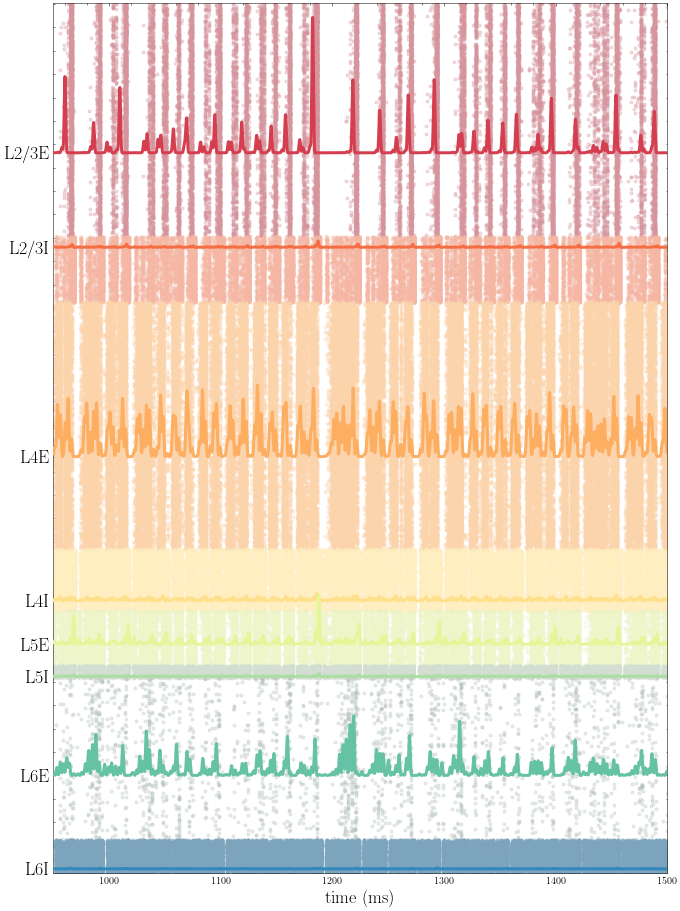

In [20]:
bg_rates = [6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0]
bg_rates = [16.0]


times_currents = np.linspace(addons.analysis_dict["analysis_start"],addons.analysis_dict["analysis_end"],num=int((addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"])/0.2))

number_of_trials = 1

pop_activities_4 = np.zeros((number_of_trials,len(bg_rates),8,len(times_currents)))
volt_currents_4 = np.zeros((number_of_trials,len(bg_rates),8,1000))
ex_currents_4 = np.zeros((number_of_trials,len(bg_rates),8,1000))
in_currents_4 = np.zeros((number_of_trials,len(bg_rates),8,1000))
lowcut_gamma = 50
highcut_gamma = 95

p0_welsh_gamma = [3000000,80,10]
p0_gamma = [30000,80,5]


p0_welsh = [3000000,10,10]
p0 = [30000,10,5]

fit_lim_low = 1
fit_lim_high = 40
fit_lim_low_gamma = 25
fit_lim_high_gamma = 125
lowcut_alpha = 8
highcut_alpha = 15

stim_time = 1133

mean_alpha_4 = np.zeros((number_of_trials,8,len(bg_rates)))
mean_gamma_4 = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_alpha_4 = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_gamma_4 = np.zeros((number_of_trials,8,len(bg_rates)))

for l in range(0,number_of_trials):
    for i in range(len(bg_rates)):
        nest.ResetKernel()
        nest.rng_seed = 1234 + l
        net = network.Network(sim_dict, net_dict, stim_dict, path = "trials_stimulation/",stim_time=stim_time)
        net.create(bg_rate=bg_rates[i],rate='fixed')
        net.connect()

        net.simulate(sim_dict["t_presim"])
        net.simulate(sim_dict["t_sim"])
        raster_plot_interval = np.array([950, 1500])
        firing_rates_interval = np.array([900,1450])

        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

        name = "trials_stimulation/"
        neuron_id = np.loadtxt(name + "population_nodeids.dat",dtype=int)
        num_neurons = []
        for j in range(len(neuron_id)):
            num_neurons = np.append(num_neurons,int(neuron_id[j][1]-neuron_id[j][0]+1))
        num_neurons = num_neurons.astype(int)

        voltage_data = addons.load_data(name,"voltmeter",)
        time_data = voltage_data[0]["time_ms"][0::num_neurons[0]]
        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
        for j in range(len(num_neurons)):
            data_pop[j] = addons.split_data(voltage_data[j], num_neurons[j])

        del(voltage_data)
        ex_current_data = addons.load_data(name,"ex_current",type="Current")
        for j in range(len(num_neurons)):
            ex_current_pop[j] = addons.split_data(ex_current_data[j],num_neurons[j],type="Current")

        del(ex_current_data)
        in_current_data = addons.load_data(name,"in_current",type="Current")
        for j in range(len(num_neurons)):
            in_current_pop[j] = addons.split_data(in_current_data[j], num_neurons[j],type="Current")
        del(in_current_data)
        volt_currents_4[l][i], ex_currents_4[l][i], in_currents_4[l][i] = prepare_data(data_pop,ex_current_pop,in_current_pop)

        pop_activity, times_a = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True,trial=l,raster=False,M=[15,15,15,15,15,15,15,15],std=[3,3,3,3,3,3,3,3])
        for k in range(len(pop_activity)):
            pop_activities_4[l][i][k] = pop_activity[k]



    pop_signal_gamma = np.zeros_like(pop_activities_4[l])



    for i in range(len(pop_activities_4[l])):
        for j in range(len(pop_activities_4[l][i])):
            pop_signal_gamma[i][j] = filter_signal(pop_activities_4[l][i][j],fs=6000,lowcut=lowcut_gamma,highcut=highcut_gamma)

    test_gamma = pop_signal_gamma.transpose(1,0,2)  

    FFT_power_gamma = {}
    Welsh_power_gamma = {}

    sigma_gamma =np.zeros((len(test_gamma),len(bg_rates)))

    for j in range(len(test_gamma)):
        FFT_power_gamma[j], freq, Welsh_freq, Welsh_power_gamma[j], mean_gamma_4[l][j][:], amplitude_gamma_4[l][j][:], sigma_gamma[j][:] = compute_FFT(test_gamma[j],save=True,test_p0 = p0_gamma,lim_x=200,plot=False,freq_sample=0.0002,low_log=40,high_log=125,freq_sample_welsh=5000,fit=True,fit_freq_start=fit_lim_low_gamma,fit_freq_end=fit_lim_high_gamma,welsh_fit='gamma',p0=p0_welsh_gamma)


    pop_signal_alpha = np.zeros_like(pop_activities_4[l])
    #Filter signal
    for i in range(len(pop_activities_4[l])):
        for j in range(len(pop_activities_4[l][i])):
            pop_signal_alpha[i][j] = filter_signal(pop_activities_4[l][i][j],fs=2000,lowcut=lowcut_alpha,highcut=highcut_alpha)


    test_alpha = pop_signal_alpha.transpose(1,0,2)

    FFT_power_alpha = {}
    Welsh_power_alpha = {}

    sigma_alpha =np.zeros((len(test_alpha),len(bg_rates)))


    for j in range(len(test_alpha)):
        FFT_power_alpha[j], freq, Welsh_freq, Welsh_power_alpha[j], mean_alpha_4[l][j][:], amplitude_alpha_4[l][j][:], sigma_alpha[j][:] = compute_FFT(test_alpha[j],save=True,fit=True,test_p0 = [300,10,5],lim_x=100,plot=False,fit_freq_start=fit_lim_low,fit_freq_end=fit_lim_high,welsh_fit='alpha',p0=p0_welsh)



    mean_alpha_final = np.mean(mean_alpha_4,axis=0)
    amplitude_alpha_final = np.mean(amplitude_alpha_4,axis=0)
    mean_gamma_final = np.mean(mean_gamma_4,axis=0)
    amplitude_gamma_final = np.mean(amplitude_gamma_4,axis=0)

    dev_mean_alpha_final = np.std(mean_alpha_4,axis=0)
    dev_amp_alpha_final = np.std(amplitude_alpha_4,axis=0)
    dev_mean_gamma_final = np.std(mean_gamma_4,axis=0)
    dev_amp_gamma_final = np.std(amplitude_gamma_4,axis=0)

(0.0, 2500.0)

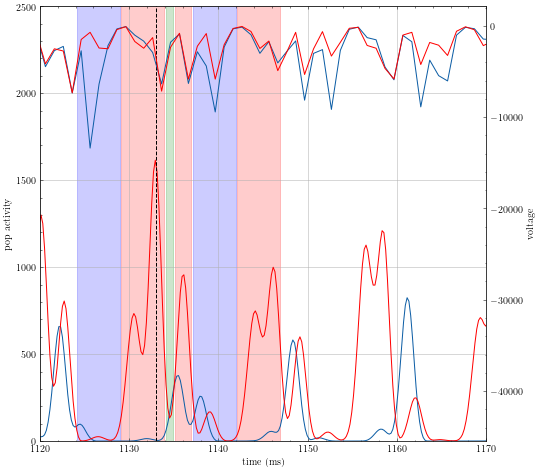

In [21]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('pop activity')
ax1.set_xlim(1120,1170)
 
ax1.plot(times_currents,pop_activities_4[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_4[0][0][2], label = 'L4E', color='red')
ax1.axvline(x=stim_time, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_4[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_4[0][0][2], label = 'L4E', color='red')


ax1.fill_between(times_currents,0,4000,where=(times_currents>=1124) & (times_currents<=1129) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1129) & (times_currents<=1134) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1134) & (times_currents<=1135) , color='green', alpha=0.2, label='smallest pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1135) & (times_currents<=1137) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1137) & (times_currents<=1142) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1142) & (times_currents<=1147) , color='red', alpha=0.2, label='high burst')
ax1.grid()
ax1.set_ylim(0,2500)


In [22]:
#Analysis for layer 4E, which is the one receiving the pulse
amplitudes_4E_1 = np.append(amplitudes_4E_1,   np.max(pop_activities_4[0][0][2][np.where((times_currents>=1124) & (times_currents<=1160))]))
delay_1_4E = np.append(delay_1_4E,1129-1124)
burst_1_4E = np.append(burst_1_4E,1134 - 1129)
pause_1_4E = np.append(pause_1_4E,1135 - 1134)
burst_2_4E = np.append(burst_2_4E,1137 - 1135)
pause_2_4E = np.append(pause_2_4E,1142-1137)
pause_3_4E = np.append(pause_3_4E,1147 - 1142)

(0.0, 2500.0)

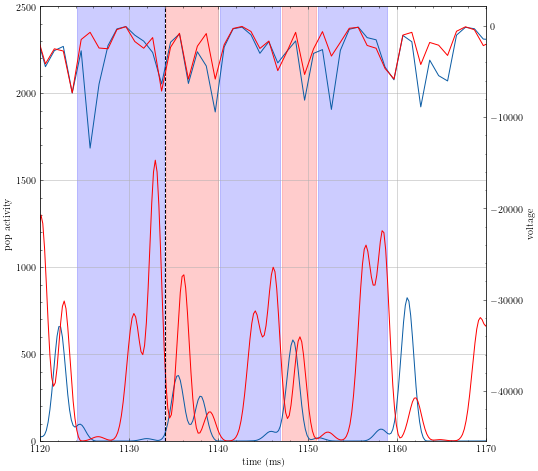

In [66]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('pop activity')
ax1.set_xlim(1120,1170)
 
ax1.plot(times_currents,pop_activities_4[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_4[0][0][2], label = 'L4E', color='red')
ax1.axvline(x=stim_time, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_4[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_4[0][0][2], label = 'L4E', color='red')


ax1.fill_between(times_currents,0,4000,where=(times_currents>=1124) & (times_currents<=1134) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1134) & (times_currents<=1140) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1140) & (times_currents<=1147) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1147) & (times_currents<=1151) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1151) & (times_currents<=1159) , color='blue', alpha=0.2, label='small pause')
ax1.grid()
ax1.set_ylim(0,2500)


In [67]:

amplitudes_2E_1 = np.append(amplitudes_2E_1,np.max(pop_activities_4[0][0][0][np.where((times_currents>=1125) & (times_currents<=1155))]))
delay_1_2E = np.append(delay_1_2E,1134-1124)
burst_1_2E = np.append(burst_1_2E,1140 - 1134)
pause_1_2E = np.append(pause_1_2E,1147 - 1140)
burst_2_2E = np.append(burst_2_2E,1151 - 1147)
pause_2_2E = np.append(pause_2_2E,1159-1151)

(0.0, 2500.0)

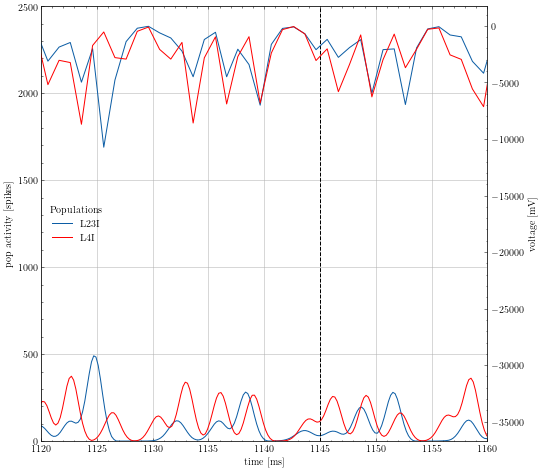

In [82]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_4[0][0][1], label = 'L23I')
ax1.plot(times_currents,pop_activities_4[0][0][3], label = 'L4I', color='red')
ax1.axvline(x=1145, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_4[0][0][1], label = 'L23I')
ax2.plot(time_volt,in_currents_4[0][0][3], label = 'L4I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

(0.0, 2500.0)

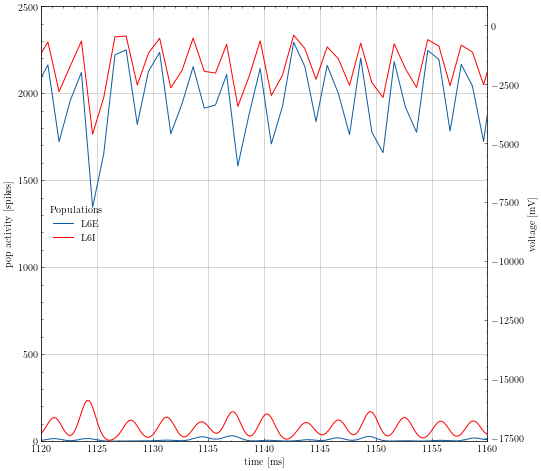

In [90]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_4[0][0][6], label = 'L6E')
ax1.plot(times_currents,pop_activities_4[0][0][7], label = 'L6I', color='red')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_4[0][0][6], label = 'L6E')
ax2.plot(time_volt,in_currents_4[0][0][7], label = 'L6I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

Data will be written to: trials_stimulation/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 10
Creating neuronal populations.

Jun 04 11:54:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating ammeters.
Creating ammeters.
Creating Poisson generators for background input.
Creating external input for external stimulation.
Connecting neuronal populations recurrently.


NodeCollection(metadata=None, model=iaf_psc_exp, size=20683, first=1, last=20683)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5834, first=20684, last=26517)
NodeCollection(metadata=None, model=iaf_psc_exp, size=21915, first=26518, last=48432)
NodeCollection(metadata=None, model=iaf_psc_exp, size=5479, first=48433, last=53911)
NodeCollection(metadata=None, model=iaf_psc_exp, size=4850, first=53912, last=58761)
NodeCollection(metadata=None, model=iaf_psc_exp, size=1065, first=58762, last=59826)
NodeCollection(metadata=None, model=iaf_psc_exp, size=14395, first=59827, last=74221)
NodeCollection(metadata=None, model=iaf_psc_exp, size=2948, first=74222, last=77169)
Connecting Poisson generators for background input.
Connecting DC generators.

Jun 04 11:54:37 NodeManager::prepare_nodes [Info]: 
    Preparing 296719 nodes for simulation.
Simulating 500.0 ms.

Jun 04 11:54:39 NodeManager::prepare_nodes [Info]: 
    Preparing 296719 nodes for simulation.

Jun 04 11:54:39 SimulationMan

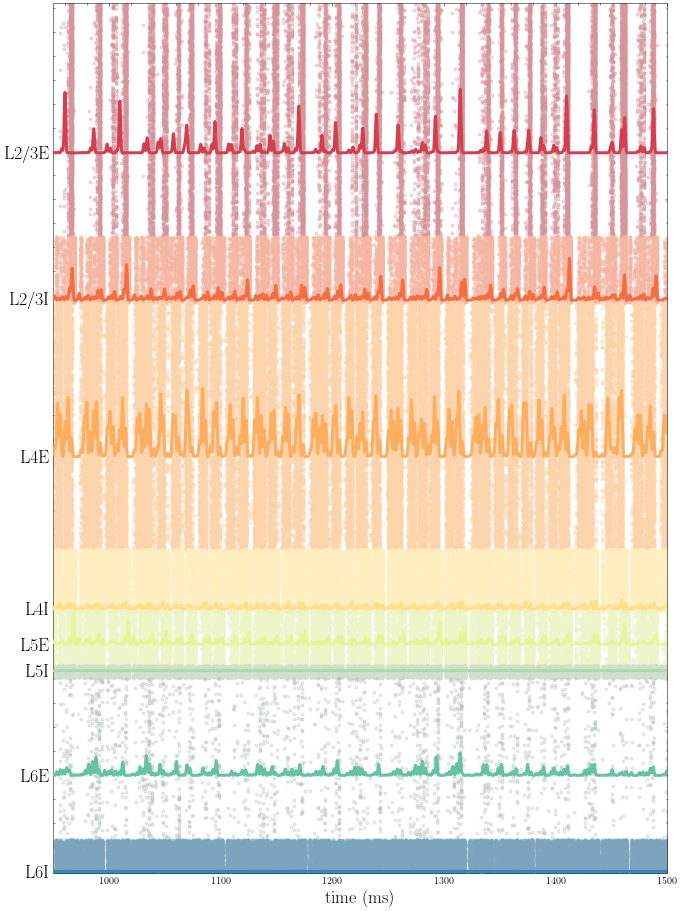

In [23]:
bg_rates = [6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0,30.0]
bg_rates = [16.0]


times_currents = np.linspace(addons.analysis_dict["analysis_start"],addons.analysis_dict["analysis_end"],num=int((addons.analysis_dict["analysis_end"]-addons.analysis_dict["analysis_start"])/0.2))

number_of_trials = 1

pop_activities_5 = np.zeros((number_of_trials,len(bg_rates),8,len(times_currents)))
volt_currents_5 = np.zeros((number_of_trials,len(bg_rates),8,1000))
ex_currents_5 = np.zeros((number_of_trials,len(bg_rates),8,1000))
in_currents_5 = np.zeros((number_of_trials,len(bg_rates),8,1000))
lowcut_gamma = 50
highcut_gamma = 95

p0_welsh_gamma = [3000000,80,10]
p0_gamma = [30000,80,5]


p0_welsh = [3000000,10,10]
p0 = [30000,10,5]

fit_lim_low = 1
fit_lim_high = 40
fit_lim_low_gamma = 25
fit_lim_high_gamma = 125
lowcut_alpha = 8
highcut_alpha = 15

stim_time = 1134

mean_alpha_5 = np.zeros((number_of_trials,8,len(bg_rates)))
mean_gamma_5 = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_alpha_5 = np.zeros((number_of_trials,8,len(bg_rates)))
amplitude_gamma_5 = np.zeros((number_of_trials,8,len(bg_rates)))

for l in range(0,number_of_trials):
    for i in range(len(bg_rates)):
        nest.ResetKernel()
        nest.rng_seed = 1234 + l
        net = network.Network(sim_dict, net_dict, stim_dict, path = "trials_stimulation/",stim_time=stim_time)
        net.create(bg_rate=bg_rates[i],rate='fixed')
        net.connect()

        net.simulate(sim_dict["t_presim"])
        net.simulate(sim_dict["t_sim"])
        raster_plot_interval = np.array([950, 1500])
        firing_rates_interval = np.array([900,1450])

        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

        name = "trials_stimulation/"
        neuron_id = np.loadtxt(name + "population_nodeids.dat",dtype=int)
        num_neurons = []
        for j in range(len(neuron_id)):
            num_neurons = np.append(num_neurons,int(neuron_id[j][1]-neuron_id[j][0]+1))
        num_neurons = num_neurons.astype(int)

        voltage_data = addons.load_data(name,"voltmeter",)
        time_data = voltage_data[0]["time_ms"][0::num_neurons[0]]
        data_pop = {}
        ex_current_pop = {}
        in_current_pop = {}
        pop_activity = {}
        names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
        for j in range(len(num_neurons)):
            data_pop[j] = addons.split_data(voltage_data[j], num_neurons[j])

        del(voltage_data)
        ex_current_data = addons.load_data(name,"ex_current",type="Current")
        for j in range(len(num_neurons)):
            ex_current_pop[j] = addons.split_data(ex_current_data[j],num_neurons[j],type="Current")

        del(ex_current_data)
        in_current_data = addons.load_data(name,"in_current",type="Current")
        for j in range(len(num_neurons)):
            in_current_pop[j] = addons.split_data(in_current_data[j], num_neurons[j],type="Current")
        del(in_current_data)
        volt_currents_5[l][i], ex_currents_5[l][i], in_currents_5[l][i] = prepare_data(data_pop,ex_current_pop,in_current_pop)

        pop_activity, times_a = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True,trial=l,raster=False,M=[15,15,15,15,15,15,15,15],std=[3,3,3,3,3,3,3,3])
        for k in range(len(pop_activity)):
            pop_activities_5[l][i][k] = pop_activity[k]



    pop_signal_gamma = np.zeros_like(pop_activities_5[l])



    for i in range(len(pop_activities_5[l])):
        for j in range(len(pop_activities_5[l][i])):
            pop_signal_gamma[i][j] = filter_signal(pop_activities_5[l][i][j],fs=6000,lowcut=lowcut_gamma,highcut=highcut_gamma)

    test_gamma = pop_signal_gamma.transpose(1,0,2)  

    FFT_power_gamma = {}
    Welsh_power_gamma = {}

    sigma_gamma =np.zeros((len(test_gamma),len(bg_rates)))

    for j in range(len(test_gamma)):
        FFT_power_gamma[j], freq, Welsh_freq, Welsh_power_gamma[j], mean_gamma_5[l][j][:], amplitude_gamma_5[l][j][:], sigma_gamma[j][:] = compute_FFT(test_gamma[j],save=True,test_p0 = p0_gamma,lim_x=200,plot=False,freq_sample=0.0002,low_log=40,high_log=125,freq_sample_welsh=5000,fit=True,fit_freq_start=fit_lim_low_gamma,fit_freq_end=fit_lim_high_gamma,welsh_fit='gamma',p0=p0_welsh_gamma)


    pop_signal_alpha = np.zeros_like(pop_activities_5[l])
    #Filter signal
    for i in range(len(pop_activities_5[l])):
        for j in range(len(pop_activities_5[l][i])):
            pop_signal_alpha[i][j] = filter_signal(pop_activities_5[l][i][j],fs=2000,lowcut=lowcut_alpha,highcut=highcut_alpha)


    test_alpha = pop_signal_alpha.transpose(1,0,2)

    FFT_power_alpha = {}
    Welsh_power_alpha = {}

    sigma_alpha =np.zeros((len(test_alpha),len(bg_rates)))


    for j in range(len(test_alpha)):
        FFT_power_alpha[j], freq, Welsh_freq, Welsh_power_alpha[j], mean_alpha_5[l][j][:], amplitude_alpha_5[l][j][:], sigma_alpha[j][:] = compute_FFT(test_alpha[j],save=True,fit=True,test_p0 = [300,10,5],lim_x=100,plot=False,fit_freq_start=fit_lim_low,fit_freq_end=fit_lim_high,welsh_fit='alpha',p0=p0_welsh)



    mean_alpha_final = np.mean(mean_alpha_5,axis=0)
    amplitude_alpha_final = np.mean(amplitude_alpha_5,axis=0)
    mean_gamma_final = np.mean(mean_gamma_5,axis=0)
    amplitude_gamma_final = np.mean(amplitude_gamma_5,axis=0)

    dev_mean_alpha_final = np.std(mean_alpha_5,axis=0)
    dev_amp_alpha_final = np.std(amplitude_alpha_5,axis=0)
    dev_mean_gamma_final = np.std(mean_gamma_5,axis=0)
    dev_amp_gamma_final = np.std(amplitude_gamma_5,axis=0)

(0.0, 2500.0)

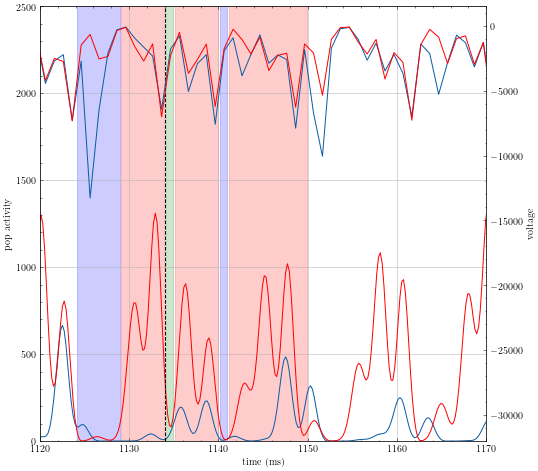

In [24]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('pop activity')
ax1.set_xlim(1120,1170)
 
ax1.plot(times_currents,pop_activities_5[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_5[0][0][2], label = 'L4E', color='red')
ax1.axvline(x=stim_time, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_5[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_5[0][0][2], label = 'L4E', color='red')


ax1.fill_between(times_currents,0,4000,where=(times_currents>=1124) & (times_currents<=1129) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1129) & (times_currents<=1134) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1134) & (times_currents<=1135) , color='green', alpha=0.2, label='smallest pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1135) & (times_currents<=1140) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1140) & (times_currents<=1141) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1141) & (times_currents<=1150) , color='red', alpha=0.2, label='high burst')
ax1.grid()
ax1.set_ylim(0,2500)


In [25]:
#Analysis for layer 4E, which is the one receiving the pulse
amplitudes_4E_1 = np.append(amplitudes_4E_1,   np.max(pop_activities_5[0][0][2][np.where((times_currents>=1124) & (times_currents<=1160))]))
delay_1_4E = np.append(delay_1_4E,1129-1124)
burst_1_4E = np.append(burst_1_4E,1134 - 1129)
pause_1_4E = np.append(pause_1_4E,1135 - 1134)
burst_2_4E = np.append(burst_2_4E,1140 - 1135)
pause_2_4E = np.append(pause_2_4E,1141-1140)

(0.0, 2500.0)

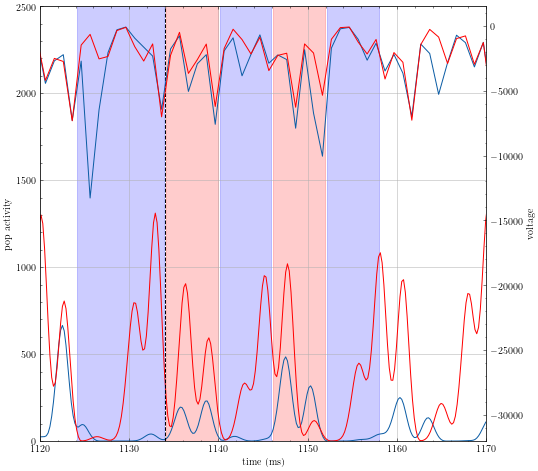

In [72]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time (ms)')
ax1.set_ylabel('pop activity')
ax1.set_xlim(1120,1170)
 
ax1.plot(times_currents,pop_activities_5[0][0][0], label = 'L23E')
ax1.plot(times_currents,pop_activities_5[0][0][2], label = 'L4E', color='red')
ax1.axvline(x=stim_time, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_5[0][0][0], label = 'L23E')
ax2.plot(time_volt,in_currents_5[0][0][2], label = 'L4E', color='red')


ax1.fill_between(times_currents,0,4000,where=(times_currents>=1124) & (times_currents<=1134) , color='blue', alpha=0.2, label='long pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1134) & (times_currents<=1140) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1140) & (times_currents<=1146) , color='blue', alpha=0.2, label='small pause')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1146) & (times_currents<=1152) , color='red', alpha=0.2, label='high burst')
ax1.fill_between(times_currents,0,4000,where=(times_currents>=1152) & (times_currents<=1158) , color='blue', alpha=0.2, label='small pause')
ax1.grid()
ax1.set_ylim(0,2500)


In [73]:

amplitudes_2E_1 = np.append(amplitudes_2E_1,np.max(pop_activities_5[0][0][0][np.where((times_currents>=1125) & (times_currents<=1155))]))
delay_1_2E = np.append(delay_1_2E,1134-1124)
burst_1_2E = np.append(burst_1_2E,1140 - 1134)
pause_1_2E = np.append(pause_1_2E,1146 - 1140)
burst_2_2E = np.append(burst_2_2E,1152 - 1146)
pause_2_2E = np.append(pause_2_2E,1158-1152)


(0.0, 2500.0)

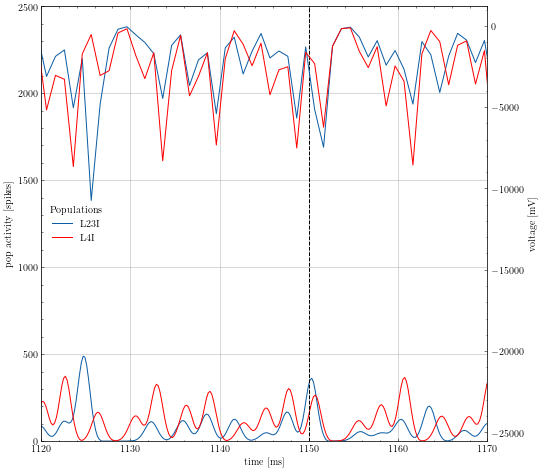

In [84]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1170)
 
ax1.plot(times_currents,pop_activities_5[0][0][1], label = 'L23I')
ax1.plot(times_currents,pop_activities_5[0][0][3], label = 'L4I', color='red')
ax1.axvline(x=1150, color='black', linestyle='--', label='Stimulation')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_5[0][0][1], label = 'L23I')
ax2.plot(time_volt,in_currents_5[0][0][3], label = 'L4I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

(0.0, 2500.0)

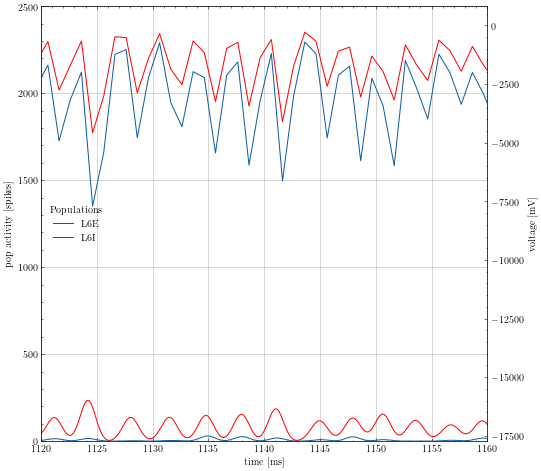

: 

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,8))

ax1.set_xlabel('time [ms]')
ax1.set_ylabel('pop activity [spikes]')
ax1.set_xlim(1120,1160)
 
ax1.plot(times_currents,pop_activities_5[0][0][6], label = 'L6E')
ax1.plot(times_currents,pop_activities_5[0][0][7], label = 'L6I', color='red')
ax2 = ax1.twinx()

ax2.set_ylabel('voltage [mV]')
time_volt = np.linspace(500,1500,num=1000)
ax2.plot(time_volt,in_currents_5[0][0][6], label = 'L6E')
ax2.plot(time_volt,in_currents_5[0][0][7], label = 'L6I', color='red')
ax2.legend(loc= 'center left', title='Populations')
ax1.grid()
ax1.set_ylim(0,2500)

Text(0.5, 1.0, 'Amplitude of L4E after stimulation')

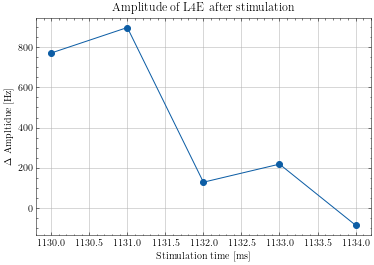

In [ ]:
stim_times = [1130,1131,1132,1133,1134]

plt.plot(stim_times, amplitudes_4E_1[1:]-amplitudes_4E_1[0], marker='o', label='Amplitude of L4E')
plt.grid()
plt.xlabel('Stimulation time [ms]')
plt.ylabel(r'$\Delta$ Ampltidue [Hz]')
plt.title('Amplitude of L4E after stimulation')
plt.title('Amplitude of L4E after stimulation')

Text(0.5, 1.0, 'Change in time scale of L4E after stimulation')

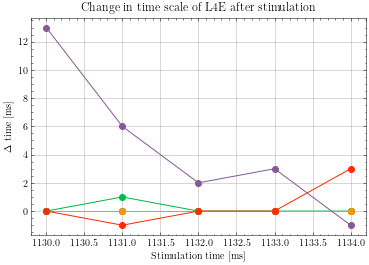

In [27]:
stim_times = [1130,1131,1132,1133,1134]

plt.plot(stim_times, delay_1_4E[1:]-delay_1_4E[0], marker='o', label='delay 1 of L4E')
plt.plot(stim_times, burst_1_4E[1:]-burst_1_4E[0], marker='o', label='burst 1 of L4E')
plt.plot(stim_times, pause_1_4E[1:]-pause_1_4E[0], marker='o', label='pause 1 of L4E')
plt.plot(stim_times, burst_2_4E[1:]-burst_2_4E[0], marker='o', label='burst 2 of L4E')
plt.plot(stim_times, pause_2_4E[1:]-pause_2_4E[0], marker='o', label='pause 2 of L4E')
plt.grid()
plt.xlabel('Stimulation time [ms]')
plt.ylabel(r'$\Delta$ time [ms]')
plt.title('Change in time scale of L4E after stimulation')

Text(0.5, 1.0, 'Amplitude of L4E after stimulation')

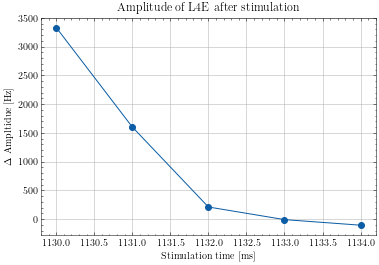

In [74]:
stim_times = [1130,1131,1132,1133,1134]

plt.plot(stim_times, amplitudes_2E_1[1:]-amplitudes_2E_1[0], marker='o', label='Amplitude of L4E')
plt.grid()
plt.xlabel('Stimulation time [ms]')
plt.ylabel(r'$\Delta$ Ampltidue [Hz]')
plt.title('Amplitude of L4E after stimulation')

Text(0.5, 1.0, 'Change in time scale of L4E after stimulation')

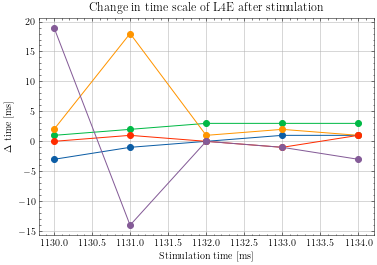

In [75]:
stim_times = [1130,1131,1132,1133,1134]

plt.plot(stim_times, delay_1_2E[1:]-delay_1_2E[0], marker='o', label='delay 1 of L4E')
plt.plot(stim_times, burst_1_2E[1:]-burst_1_2E[0], marker='o', label='burst 1 of L4E')
plt.plot(stim_times, pause_1_2E[1:]-pause_1_2E[0], marker='o', label='pause 1 of L4E')
plt.plot(stim_times, burst_2_2E[1:]-burst_2_2E[0], marker='o', label='burst 2 of L4E')
plt.plot(stim_times, pause_2_2E[1:]-pause_2_2E[0], marker='o', label='pause 2 of L4E')
plt.grid()
plt.xlabel('Stimulation time [ms]')
plt.ylabel(r'$\Delta$ time [ms]')
plt.title('Change in time scale of L4E after stimulation')